### Importing all Necessary Packages 

In [19]:
import torch 
import gensim
from IPython.display import display
# Data processing
import numpy as np
# Text preprocessiong~
import nltk
from nltk.corpus import stopwords

################################################ Just to Ensure these are donwnloaded on the local machine ################################################
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
################################################ Just to Ensure these are donwnloaded on the local machine ################################################

# Topic model
from bertopic import BERTopic
# Dimension reduction
from umap import UMAP
#Modules
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.test.utils 
import spacy
import en_core_web_sm
import nltk 

################################################ If needed on the local machine ################################################
#nltk.download('stopwords') - if needed
################################################ If needed on the local machine ################################################

from nltk.corpus import stopwords
import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kushk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kushk\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kushk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Reading the Dataset with President Speeches, Titles, Summary and Their affliation with the Party

In [20]:
df = pd.read_csv('US-president-speeches-with-metadata-test.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df = df.fillna(value= '')

### Plotting the numeber of speeches for each president

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 [Text(0, 0, 'George Washington'),
  Text(1, 0, 'John Adams'),
  Text(2, 0, 'Thomas Jefferson'),
  Text(3, 0, 'James Madison'),
  Text(4, 0, 'James Monroe'),
  Text(5, 0, 'John Quincy Adams'),
  Text(6, 0, 'Andrew Jackson'),
  Text(7, 0, 'Martin Van Buren'),
  Text(8, 0, 'William Harrison'),
  Text(9, 0, 'John Tyler'),
  Text(10, 0, 'James K. Polk'),
  Text(11, 0, 'Zachary Taylor'),
  Text(12, 0, 'Millard Fillmore'),
  Text(13, 0, 'Franklin Pierce'),
  Text(14, 0, 'James Buchanan'),
  Text(15, 0, 'Abraham Lincoln'),
  Text(16, 0, 'Andrew Johnson'),
  Text(17, 0, 'Ulysses S. Grant'),
  Text(18, 0, 'Rutherford B. Hayes'),
  Text(19, 0, 'James A. Garfield'),
  Text(20, 0, 'Chester A. Arthur'),
  Text(21, 0, 'Grover Cleveland'),
  Text(22, 0, 'Benjamin Harrison'),
  Text(23, 0, 'William 

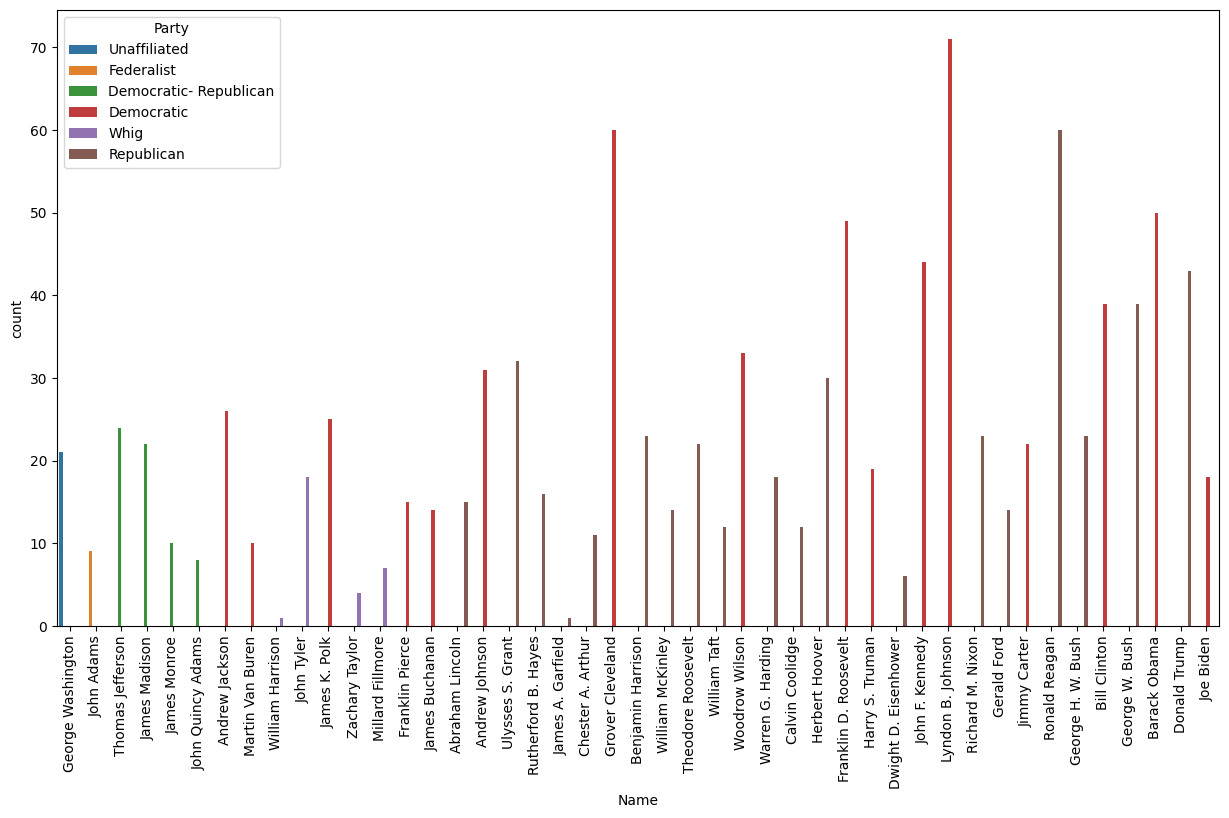

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt
dfcheck = pd.read_csv('./US-president-speeches-with-metadata.csv')
plt.figure(figsize=(15,8))
sns.countplot(data=dfcheck, x = 'Name', hue='Party')
plt.xticks(rotation=90)

### Helper Functions to clean the dataset and put columns with right datatypes

In [22]:
def todatetime(dataframe : pd.DataFrame, datecols : list[str] = ['Date']) -> pd.DataFrame:
    '''
    Function to convert all the different date columns columns into pandas datetime format
    '''
    dataframe1 = dataframe.copy()
    for cols in datecols:
        dataframe1[cols] = pd.to_datetime(dataframe1[cols])
    return dataframe1


def generate_stopwords(dataframe : pd.DataFrame, text_col : str = 'Speech') -> list[str]:
    '''
    Generating a list of stopwords, some might not be in the nltk corpus
    '''
    stop_words2 = ['united', 'state', 'states', 'president', 'don', 'thank', 'mr', 'america', 're',
               've', 'applause', 'transcript', 'anscript', 'country', 'good evening', 'please']
    stop_words = stopwords.words('english')
    total_stopwords = stop_words + stop_words2
    return total_stopwords


# Some Code taken from https://github.com/kkap250901/Stock-Prediction/blob/Collecting-Data/Macro-analysis.ipynb which is my own github page
def cleaning(dataframe : pd.DataFrame, cleaning_cols : list[str] = ['Speech', 'Title', 'Speech_Summary']) -> pd.DataFrame:
    '''
    Cleaning funciton to handle all the preprocessing and stopwards removal as well the lemmatization
    '''
    dataframe1 = dataframe.copy()
    # First just keeping words and removing special characters in this case
    dataframe1[cleaning_cols] = dataframe1[cleaning_cols].replace('[^a-zA-Z]'," ",regex = True)
    # Getting all the stopwords
    all_stopwords = generate_stopwords(dataframe1)
    wnl = nltk.WordNetLemmatizer()

    
    for col in cleaning_cols:
        processed = []
        for i in range(len(dataframe1[col])):
            # Lowering all the sentences before stemming and lemmatosation
            processing = str(dataframe1[col][i]).lower()
            processing = nltk.word_tokenize(processing)
            processing = [wnl.lemmatize(word) for word in processing if word not in all_stopwords]
            final = ' '.join(processing)
            processed.append(final)
        # This is to get the right values in the column
        dataframe1[col] = processed
    return dataframe1


def attaching_periods(dataframe : pd.DataFrame, timecol : str = 'Date') -> pd.DataFrame :
    """
    Attching time periods to the speeches according to the Mili centre
    * `Early Republic (1789–1829)`
    * `Jacksonian Democracy(1829–1853)`
    * `Sectional Conflict (1853–1881)`
    * `Gilded Age (1881–1897)`
    * `Progressive Era (1897–1921)`
    * `Depression and World Conflict(1921–1961)`
    * `Social Change and Soviet Relations (1961–1989)`
    * `Globalization(1989–)`
    """
    dataframe1 = dataframe.copy()
    dataframe1['Year'] = dataframe1['Date'].dt.year
    time_periods = []
    for year in dataframe1['Year']:
        if year <= 1829 and year >= 1789:
            time_periods.append('Early Republic')
        elif year <= 1853 and year >= 1829:
            time_periods.append('Jacksonian Democracy')
        elif year <= 1881 and year >= 1853:
            time_periods.append('Sectional Conflict')
        elif year <= 1897 and year >= 1881:
            time_periods.append('Gilded Age')
        elif year <= 1921 and year >= 1897:
            time_periods.append('Progressive Era')
        elif year <= 1961 and year >= 1921:
            time_periods.append('Depression and World Conflict')
        elif year <= 1989 and year >= 1961:
            time_periods.append('Social Change and Soviet Relations')
        elif year >= 1989:
            time_periods.append('Globalization')
    
    dataframe1['Time_Periods'] = time_periods
    return dataframe1

def Word2vec(dataframe : pd.DataFrame, textcols : str = ['Title', 'Speech_Summary', 'Speech'], params : dict = None):
    """
    Rhis is to create a word2vec model form the dataframe trained on all the textual columns
    """
    dataframe1 = dataframe.copy()
    dataframe1['Total'] = dataframe1[textcols[0]] + '.' + dataframe1[textcols[1]] + '.' +dataframe1[textcols[2]]
    dataframe1['Total'] = dataframe1['Total'].apply(str.lower)
    vec = [nltk.word_tokenize(speech) for speech in dataframe1['Total']]
    model = gensim.models.Word2Vec(vec, **params)
    return model


### Making a new dataframe here with right datetime format
Also getting cleaning the data but also maintaining a copy of a dataframe which is not cleaned 
as in some later models cleaning done from scratch

In [23]:
# Correct Date time format
df1 = todatetime(df)

# Cleaning the speeches, Titles and Summary so basically all the textual columns 
df1 = cleaning(df1)

# Attaching the periods to the dataframe so can be filtered later on
df1 = attaching_periods(df1)

In [24]:
# Just doing this to the original dataframe without the cleaning because with some models custom cleaning is done
df = todatetime(df)

# But this dataframe will still have all the relevant indo
df = attaching_periods(df)

### Investigating if the dataset is correct and seeing if there is any missing data

In [25]:
display(df[df['Party'] == 'Democratic'].head())
display(df[df['Party'] == 'Republican'].head())
df[df.Year < 1980]

,Name,Party,From,To,Date,Title,Speech_Summary,Speech,Year,Time_Periods
94,Andrew Jackson,Democratic,1829,1837,1837-03-04,Farewell Address,,Fellow-Citizens:Being about to retire finally ...,1837,Jacksonian Democracy
95,Andrew Jackson,Democratic,1829,1837,1836-12-21,Statement on the Independence of Texas,,To the Senate and House of Representatives of ...,1836,Jacksonian Democracy
96,Andrew Jackson,Democratic,1829,1837,1836-12-05,Eighth Annual Message to Congress,"In his final annual address, Jackson gives a p...",Fellow citizens of the Senate and House of Rep...,1836,Jacksonian Democracy
97,Andrew Jackson,Democratic,1829,1837,1835-12-07,Seventh Annual Address to Congress,Jackson gives a detailed account of the ruptur...,Fellow Citizens of the Senate and House of Rep...,1835,Jacksonian Democracy
98,Andrew Jackson,Democratic,1829,1837,1834-12-01,Sixth Annual Message to Congress,"President Jackson seeks to regulate banks, reo...",Fellow Citizens of the Senate and House of Rep...,1834,Jacksonian Democracy


,Name,Party,From,To,Date,Title,Speech_Summary,Speech,Year,Time_Periods
214,Abraham Lincoln,Republican,1861,1865,1865-03-04,Second Inaugural Address,"Just over a month before his assassination, Li...",Fellow-Countrymen: At this second appearing to...,1865,Sectional Conflict
215,Abraham Lincoln,Republican,1861,1865,1864-12-06,Fourth Annual Message,,Fellow-Citizens of the Senate and House of Rep...,1864,Sectional Conflict
216,Abraham Lincoln,Republican,1861,1865,1863-12-08,Third Annual Message,,Fellow-Citizens of the Senate and House of Rep...,1863,Sectional Conflict
217,Abraham Lincoln,Republican,1861,1865,1863-11-19,Gettysburg Address,"Four months after the Battle of Gettysburg, Li...",Four score and seven years ago our fathers bro...,1863,Sectional Conflict
218,Abraham Lincoln,Republican,1861,1865,1863-08-26,Public Letter to James Conkling,President Lincoln wrote this letter to his fri...,"Executive Mansion, Washington, August 26, 186...",1863,Sectional Conflict


,Name,Party,From,To,Date,Title,Speech_Summary,Speech,Year,Time_Periods
0,George Washington,Unaffiliated,1789,1797,1796-12-07,Eighth Annual Message to Congress,Making his last public appearance as President...,Fellow Citizens of the Senate and House of Re...,1796,Early Republic
1,George Washington,Unaffiliated,1789,1797,1796-09-19,Farewell Address,In one of the most famous addresses in America...,The period for a new election of a citizen to ...,1796,Early Republic
2,George Washington,Unaffiliated,1789,1797,1796-08-29,Talk to the Cherokee Nation,,"Beloved Cherokees,Many years have passed since...",1796,Early Republic
3,George Washington,Unaffiliated,1789,1797,1796-03-30,"Message to the House of Representatives, Decli...","In 1796, the House and the Senate were battlin...",Gentlemen of the House of Representatives: W...,1796,Early Republic
4,George Washington,Unaffiliated,1789,1797,1795-12-08,Seventh Annual Message to Congress,Washington’s 1795 speech is imbued with a sen...,I trust I do not deceive myself when I indulge...,1795,Early Republic
...,...,...,...,...,...,...,...,...,...,...
790,Jimmy Carter,Democratic,1977,1981,1976-10-06,Debate with President Gerald Ford (Foreign and...,,Good evening. I am Pauline Frederick ...,1976,Social Change and Soviet Relations
791,Jimmy Carter,Democratic,1977,1981,1976-09-23,Debate with President Gerald Ford (Domestic Is...,,"I am Edwin Newman, moderator of this ...",1976,Social Change and Soviet Relations
849,Ronald Reagan,Republican,1981,1989,1979-11-13,Announcement for Presidential Candidacy,,Good evening. I am here tonight to an...,1979,Social Change and Soviet Relations
850,Ronald Reagan,Republican,1981,1989,1976-08-19,Remarks at the Republican National Convention,,"Mr. President, Mrs. Ford, Mr. Vice Pr...",1976,Social Change and Soviet Relations


### Exploratory data analysis with the use of Sentiment analysis models

#### Polarity vs Subjectivity of president wise speeches to measure opinion vs fact

#### Also Polarity vs Subjectivity of Party wise, this is done to see if some president is very subjective(opinionated) or if other presidents are very factual 

#### Expecting to see Donald Trump at the top right with most polar and most subjective speeches

In [26]:
from transformers import pipeline
import math
from textblob import TextBlob


classify = pipeline(
    task="text-classification",
    model="cffl/bert-base-styleclassification-subjective-neutral",
    return_all_scores=True)

def longerdoc(longerdoc : str) -> float:
    '''
    For longer documents as more than 512 tokens bert doesnt work due to the O(n2) time complexity
    '''

   # Get partition ranges
    length = len(longerdoc)
    n=math.ceil(length/512)
    partition_size = math.ceil(length/n)
    partition = np.arange(0, length, partition_size)
    
    # split longerdoc
    initial = 0 
    i = 0
    for split in range(n):
        initial += classify(longerdoc[partition[split]:partition[split]+partition_size])[0][0]['score']
        i += 1

    return initial/i
    

def sub_polarity(dataframe : pd.DataFrame, col : str = 'Speech', Bert_sub : bool = False, Bert_sent : bool = True) -> pd.DataFrame:
    
    '''
    Different Sentiment Anlysers used 
    1) Vader 
    2) Nltk Sentiment Analyser
    3) Text Blob

    Differnt Fact vs opinion analysers used
    1) Text Blob
    2) BERT based classifier 
    '''
    
    # Initialising everything
    dataframe1 = dataframe.copy()

    # First just using text blob
    pol = lambda x: TextBlob(x).sentiment.polarity
    sub = lambda x: TextBlob(x).sentiment.subjectivity
    dataframe1['Polarity_Blob'] = dataframe1.apply(lambda x: pol(x[col]),axis=1)
    dataframe1['Subjective'] = dataframe1.apply(lambda x: sub(x[col]),axis=1)


    # BERT based models from Hugging face take very long to run so turned to false 
    if Bert_sub: 
       dataframe1['Subjective_Bert'] = dataframe1.apply(lambda x : longerdoc(x[col]),axis=1)


    # Vader Sentiment Analyser   
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    sid_obj = SentimentIntensityAnalyzer()
    dataframe1['Polarity_vader'] = dataframe1.apply(lambda x: sid_obj.polarity_scores(x[col])['compound'],axis=1)

    # 2) Ntlk Sentiment Analyser
    from nltk.sentiment import SentimentIntensityAnalyzer
    import operator
    sia = SentimentIntensityAnalyzer()
    dataframe1["Polarity_nltk"] = dataframe1[col].apply(lambda x: sia.polarity_scores(x)["compound"])

    return dataframe1


def president_polarity(dataframe : pd.DataFrame, col : list[str] = ['Polarity_Blob', 'Subjective', 'Polarity_vader','Polarity_nltk']) -> pd.DataFrame:
    '''
    This is for avg polarity 
    '''
    dataframe1 = dataframe.copy()
    dataframe1['Party'] = dataframe1['Party'].apply(lambda x : 'Other' if x not in ['Democratic', 'Republican'] else x)
    return (dataframe1.groupby(['Name','Party'])[col].mean()).reset_index()


### Making a temporay dataset just for the globalisation period as thats what we are observing and making conclusions from

In [ ]:
df_glob_temp_for_polarity = df1[df1.Time_Periods == 'Globalization']

#### Running the funcitons from above

In [ ]:
df2 = sub_polarity(df_glob_temp_for_polarity)
### This funciton takes a lot of time to run as it calculates the polarity from 3 different models for all presidents over all time ###
df2_all = sub_polarity(df1)
### This funciton takes a lot of time to run as it calculates the polarity from 3 different models for all presidents over all time ###
#### run only if needed otherwise produced results in df_polar_all
# df1 = df[df.]
dfpolar = president_polarity(df2)

### Just outputting polarity for the speeches in a dataframe format so it can be plotted 

In [ ]:
dfpolar_all = president_polarity(df2_all)

### Just making sure as this the globalisation version so only 2 parties should exist

In [ ]:
dfpolar.Party.unique()

array(['Democratic', 'Republican'], dtype=object)

In [ ]:
dfpolar.head()

,Name,Party,Polarity_Blob,Subjective,Polarity_vader,Polarity_nltk
0,Barack Obama,Democratic,0.106648,0.429293,0.957564,0.955648
1,Bill Clinton,Democratic,0.115645,0.420662,0.937526,0.889649
2,Donald Trump,Republican,0.151029,0.488148,0.777981,0.742049
3,George H. W. Bush,Republican,0.107075,0.434679,0.997488,0.997176
4,George W. Bush,Republican,0.123455,0.441076,0.731733,0.739262
5,Joe Biden,Democratic,0.097752,0.397176,0.778767,0.830000


In [ ]:
dfpolar_all

,Name,Party,Polarity_Blob,Subjective,Polarity_vader,Polarity_nltk
0,Abraham Lincoln,Republican,0.133439,0.456141,0.859107,0.691467
1,Andrew Jackson,Democratic,0.098781,0.427089,0.988477,0.982231
2,Andrew Johnson,Democratic,0.064026,0.396401,0.756926,0.747281
3,Barack Obama,Democratic,0.106648,0.429293,0.957564,0.955648
4,Benjamin Harrison,Republican,0.137687,0.458116,0.827678,0.827635
5,Bill Clinton,Democratic,0.115645,0.420662,0.937526,0.889649
6,Calvin Coolidge,Republican,0.141845,0.435084,0.999842,0.999858
7,Chester A. Arthur,Republican,0.108741,0.432250,0.985655,0.985191
8,Donald Trump,Republican,0.151029,0.488148,0.777981,0.742049
9,Dwight D. Eisenhower,Republican,0.131117,0.461723,0.999833,0.999817


In [ ]:
dfpolar.head()

,Name,Party,Polarity_Blob,Subjective,Polarity_vader,Polarity_nltk
0,Barack Obama,Democratic,0.106648,0.429293,0.957564,0.955648
1,Bill Clinton,Democratic,0.115645,0.420662,0.937526,0.889649
2,Donald Trump,Republican,0.151029,0.488148,0.777981,0.742049
3,George H. W. Bush,Republican,0.107075,0.434679,0.997488,0.997176
4,George W. Bush,Republican,0.123455,0.441076,0.731733,0.739262
5,Joe Biden,Democratic,0.097752,0.397176,0.778767,0.830000


### Plotting polarity calculated by textblob vs subjective claculted by text blob

Text(203.97222222222223, 0.5, 'Subjectivity')

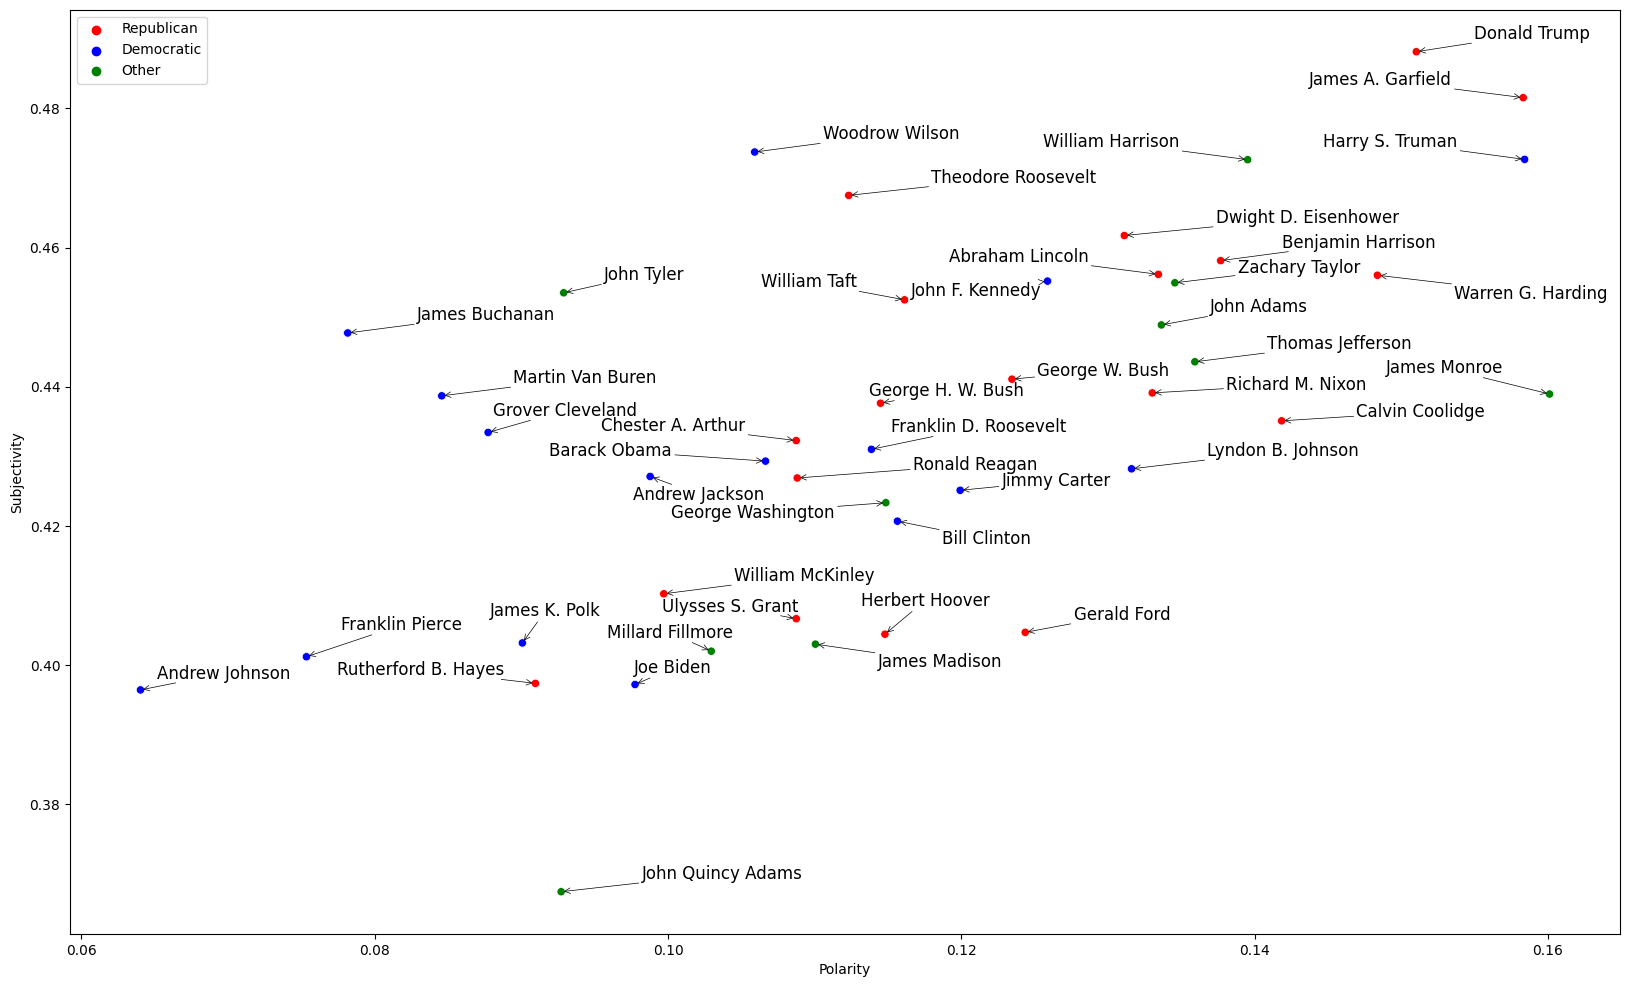

In [ ]:
from adjustText import adjust_text

fig,ax = plt.subplots(figsize=(20,12),ncols=1,nrows=1)

sns.scatterplot(x='Polarity_Blob', # Horizontal axis
       y='Subjective', # Vertical axis
       data=dfpolar_all, # Data source
       ax=ax,
       hue='Party',
       palette=['Red','Blue','Green'])  

TEXTS = []
for i in range(len(dfpolar_all)):
     x = dfpolar_all["Polarity_Blob"].iloc[i]
     y = dfpolar_all["Subjective"].iloc[i]
     text = dfpolar_all.Name.iloc[i]
     TEXTS.append(ax.text(x, y, text, fontsize=12))

adjust_text(
    TEXTS,
    expand_points=(2, 2),
    arrowprops=dict(arrowstyle="->",lw=0.5),
    ax=fig.axes[0]
)

ax.legend(loc = 'upper left')
# Set x-axis label
plt.xlabel('Polarity')
# Set y-axis label
plt.ylabel('Subjectivity')


### Plotting polarity calculated by textblob vs subjective claculted by text blob but only for presidents in the Globalisation era
<b> As expected Donald Trump is the most polar and most opinionated president during this era </b>
##### Interesting how democrats are less Subjective than all republican presidents

Text(78.97222222222221, 0.5, 'Subjectivity')

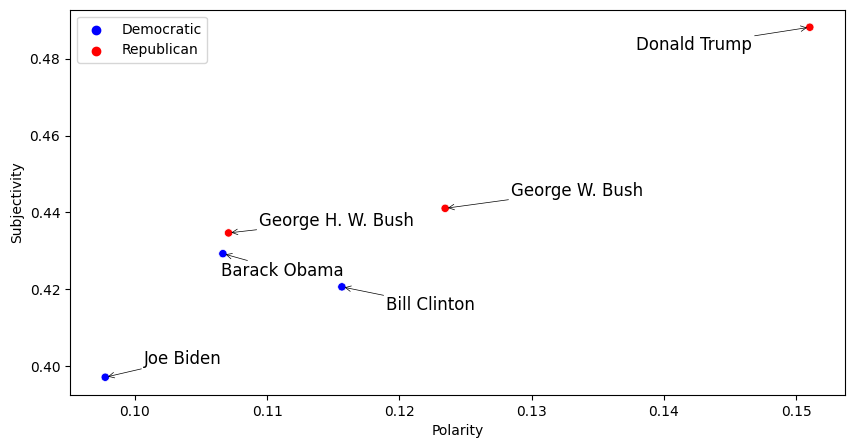

In [ ]:
from adjustText import adjust_text

fig,ax = plt.subplots(figsize=(10,5),ncols=1,nrows=1)

sns.scatterplot(x='Polarity_Blob', # Horizontal axis
       y='Subjective', # Vertical axis
       data=dfpolar, # Data source
       ax=ax,
       hue='Party',
       palette=['Blue','Red','Green'])  

TEXTS = []
for i in range(len(dfpolar)):
     x = dfpolar["Polarity_Blob"].iloc[i]
     y = dfpolar["Subjective"].iloc[i]
     text = dfpolar.Name.iloc[i]
     TEXTS.append(ax.text(x, y, text, fontsize=12))

adjust_text(
    TEXTS,
    expand_points=(2, 2),
    arrowprops=dict(arrowstyle="->",lw=0.5),
    ax=fig.axes[0]
)

ax.legend(loc = 'upper left')
# Set x-axis label
plt.xlabel('Polarity')
# Set y-axis label
plt.ylabel('Subjectivity')


## Topic Modelling with the use of Bertopic
##### Due to the fact that in comparison to LDA and NMF whiich use bag of words approach this considers sentiments of the text
##### Although only suitable for smaller text documents and assigns one topic to each document hence why I realised its not suitable for my pipline ahead to filter speeches based on topic, summmary to be able to make best possible direct comparisons

### 1) Document Embedding, using sentence transformers 

### 2) Document Clustering 
     * After the text documents have been transformed into embeddings, the next step is to run a clustering model on the embedded documents.

### 3) Topic Representation 
    * After assigning each document in the corpus into a cluster, the next step is to get the topic representation using a class-based TF-IDF called c-TF-IDF#

### 4) Maximal Marginal Relevance (MMR)
     * The first benefit is to increase the coherence among the terms for the same topic and remove irrelevant terms.
     * The seco
     nd benefit is to increase the topic representation by removing synonyms and variations of the same words.

### Topic Modelling with the use of BERTtopic
* Uses UMAP Model to reduce dimensionality 
* Uses clustering algorithm
* Uses sentence transformers for embeddings 
* Uses cTF-IDF for topic representation 
* MMR optional but useful with some advantages

In [ ]:
df1.dtypes

Name                      object
Party                     object
From                       int64
To                         int64
Date              datetime64[ns]
Title                     object
Speech_Summary            object
Speech                    object
Year                       int64
Time_Periods              object
dtype: object

In [ ]:
df_republican_glob = df1[(df1['Year'] > 1980) & (df1['Party'] == 'Republican')]
republican_globalisation_speeches = df_republican_glob['Speech'].reset_index(drop=True)
# Initiate UMAP
umap_model = UMAP(n_neighbors=6, 
                  n_components=3, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)

# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model, language="english",calculate_probabilities=True,min_topic_size=3)

# Run BERTopic model
topics, probabilities = topic_model.fit_transform(republican_globalisation_speeches )

In [ ]:
republican_globalisation_speeches

0      th time speak oval office last together eight ...
1      well much warm welcome governor baliles congre...
2      much seated live today remember know freedom r...
3      general secretary distinguished delegate half ...
4      madam chairman delegate convention fellow citi...
                             ...                        
156    trump secretary general world leader distingui...
157    trump everybody much thrilled thrilled think e...
158    everybody much well want everybody stage reall...
159    speaker vice member congress first lady citize...
160    chief justice robert carter clinton bush obama...
Name: Speech, Length: 161, dtype: object

In [ ]:
df_democrat_glob= df1[(df1['Year'] > 1980) & (df1['Party'] == 'Democratic')]
democratic_globalisation_speeches = df_democrat_glob['Speech'].reset_index(drop=True)
# Initiate UMAP
umap_model = UMAP(n_neighbors=5, 
                  n_components=1, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)

# Initiate BERTopic
topic_model2 = BERTopic(umap_model=umap_model, language="english",calculate_probabilities=True,min_topic_size=3)

# Run BERTopic model
topics2, probabilities2 = topic_model2.fit_transform(democratic_globalisation_speeches)

In [ ]:
# Get the list of topics
n_1 = topic_model.get_topic_info()
# Get the list of topics
n_2 = topic_model2.get_topic_info()

In [ ]:
display(n_1,n_2)

,Topic,Count,Name
0,-1,35,-1_people_american_one_know
1,0,22,0_going_know_want_people
2,1,17,1_people_year_want_know
3,2,12,2_iraq_iraqi_force_saddam
4,3,8,3_american_must_nation_terrorist
5,4,8,4_soviet_gorbachev_would_one
6,5,8,5_nation_world_peace_regime
7,6,7,6_great_one_war_year
8,7,7,7_tax_cut_year_bill
9,8,6,8_year_government_tax_black


,Topic,Count,Name
0,-1,12,-1_american_year_new_people
1,0,25,0_going_people_think_american
2,1,14,1_peace_world_must_people
3,2,8,2_victim_right_law_american
4,3,7,3_going_get_vaccinated_know
5,4,6,4_afghanistan_afghan_taliban_al
6,5,6,5_russia_ukraine_cuban_world
7,6,6,6_year_american_job_new
8,7,4,7_american_insurance_year_health
9,8,4,8_region_somalia_assad_people


In [ ]:
# Get the list of topics
n_1 = topic_model.get_topic_info()
display(n_1)
# To get the representative documents
representative_speeches = topic_model.get_representative_docs(0)

display(n_1,n_2)
# Get top 10 terms for a topic
display(topic_model.get_topic(1))

# Visualize top topic keywords
display(topic_model.visualize_barchart(top_n_topics=15))


# Visualize term rank decrease
display(topic_model.visualize_term_rank())


# Visualize intertopic distance
display(topic_model.visualize_topics())


# Visualize connections between topics using hierachical clustering
display(topic_model.visualize_hierarchy(top_n_topics=10))


# Visualize similarity using heatmap
display(topic_model.visualize_heatmap())


# Visualize probability distribution
display(topic_model.visualize_distribution(topic_model.probabilities_[0], min_probability=0.015))


,Topic,Count,Name
0,-1,35,-1_people_american_one_know
1,0,22,0_going_know_want_people
2,1,17,1_people_year_want_know
3,2,12,2_iraq_iraqi_force_saddam
4,3,8,3_american_must_nation_terrorist
5,4,8,4_soviet_gorbachev_would_one
6,5,8,5_nation_world_peace_regime
7,6,7,6_great_one_war_year
8,7,7,7_tax_cut_year_bill
9,8,6,8_year_government_tax_black


,Topic,Count,Name
0,-1,35,-1_people_american_one_know
1,0,22,0_going_know_want_people
2,1,17,1_people_year_want_know
3,2,12,2_iraq_iraqi_force_saddam
4,3,8,3_american_must_nation_terrorist
5,4,8,4_soviet_gorbachev_would_one
6,5,8,5_nation_world_peace_regime
7,6,7,6_great_one_war_year
8,7,7,7_tax_cut_year_bill
9,8,6,8_year_government_tax_black


,Topic,Count,Name
0,-1,12,-1_american_year_new_people
1,0,25,0_going_people_think_american
2,1,14,1_peace_world_must_people
3,2,8,2_victim_right_law_american
4,3,7,3_going_get_vaccinated_know
5,4,6,4_afghanistan_afghan_taliban_al
6,5,6,5_russia_ukraine_cuban_world
7,6,6,6_year_american_job_new
8,7,4,7_american_insurance_year_health
9,8,4,8_region_somalia_assad_people


[('people', 0.0231112797636237),
 ('year', 0.01924233850046893),
 ('want', 0.016050710098300426),
 ('know', 0.01594149161090107),
 ('american', 0.015749826306787364),
 ('great', 0.015410737268244226),
 ('said', 0.0152464223702267),
 ('tax', 0.015204364090773963),
 ('going', 0.015128268629482114),
 ('one', 0.014936438562895355)]

In [ ]:
# Get the list of topics
n_1 = topic_model2.get_topic_info()
display(n_1)
# To get the representative documents
representative_speeches = topic_model2.get_representative_docs(0)

# Get top 10 terms for a topic
display(topic_model2.get_topic(1))

# Visualize top topic keywords
display(topic_model2.visualize_barchart(top_n_topics=15))


# Visualize term rank decrease
display(topic_model2.visualize_term_rank())


# Visualize intertopic distance
display(topic_model2.visualize_topics())


# Visualize connections between topics using hierachical clustering
display(topic_model2.visualize_hierarchy(top_n_topics=10))


# Visualize similarity using heatmap
display(topic_model2.visualize_heatmap())


# Visualize probability distribution
display(topic_model2.visualize_distribution(topic_model2.probabilities_[0], min_probability=0.015))


,Topic,Count,Name
0,-1,12,-1_american_year_new_people
1,0,25,0_going_people_think_american
2,1,14,1_peace_world_must_people
3,2,8,2_victim_right_law_american
4,3,7,3_going_get_vaccinated_know
5,4,6,4_afghanistan_afghan_taliban_al
6,5,6,5_russia_ukraine_cuban_world
7,6,6,6_year_american_job_new
8,7,4,7_american_insurance_year_health
9,8,4,8_region_somalia_assad_people


[('peace', 0.04099634590154307),
 ('world', 0.030430069327799347),
 ('must', 0.028589233274682026),
 ('people', 0.027921042369247695),
 ('war', 0.026140088791959896),
 ('israel', 0.02398553122303567),
 ('nation', 0.021138693950205664),
 ('human', 0.017279267914454877),
 ('new', 0.016115304021288183),
 ('palestinian', 0.01553615973479594)]

In [ ]:
# Get the topic predictions
topic_prediction = topic_model.topics_[:]

In [ ]:
topic_prediction
# Get the topic predictions
# topic_prediction = topic_model.topics_[:]
# # Save the predictions in the dataframe
# df1['topic_prediction'] = topic_prediction
# # Take a look at the data
# df1.head()
# investigating = pd.DataFrame(df1.groupby('topic_prediction')['Name'].value_counts())
# display(investigating)  

[10,
 1,
 -1,
 5,
 8,
 4,
 1,
 4,
 4,
 14,
 9,
 1,
 1,
 4,
 0,
 -1,
 1,
 8,
 4,
 0,
 1,
 -1,
 12,
 12,
 8,
 6,
 -1,
 -1,
 10,
 -1,
 1,
 11,
 -1,
 11,
 2,
 4,
 -1,
 -1,
 8,
 -1,
 11,
 11,
 7,
 5,
 14,
 14,
 1,
 1,
 5,
 0,
 7,
 8,
 6,
 1,
 7,
 -1,
 6,
 1,
 0,
 12,
 9,
 -1,
 4,
 9,
 2,
 4,
 2,
 7,
 5,
 9,
 2,
 1,
 14,
 3,
 1,
 7,
 -1,
 12,
 -1,
 13,
 -1,
 7,
 15,
 7,
 -1,
 3,
 15,
 15,
 2,
 -1,
 3,
 2,
 0,
 0,
 3,
 3,
 8,
 6,
 3,
 -1,
 -1,
 9,
 2,
 2,
 3,
 5,
 0,
 2,
 6,
 3,
 1,
 -1,
 0,
 -1,
 15,
 -1,
 0,
 13,
 13,
 0,
 0,
 0,
 -1,
 10,
 10,
 0,
 0,
 -1,
 1,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 -1,
 2,
 2,
 2,
 -1,
 5,
 -1,
 -1,
 0,
 5,
 6,
 -1,
 1,
 0,
 1,
 10,
 -1,
 9,
 5,
 13,
 -1,
 -1,
 -1]

### Topic Modelling using NMF
#### Another bag of words model but trying this as well as LDA. This is the scikit learn implementation of NMF 
#### The reason for implementing in sckit learn here is that it is easier to group topics by decade, whereas gensim is restricitve in that case, furthermore in a researhc paper I found NMF applied to European parliament speeches with good performance, but regardless i tried LDA as its the most conventional model out there
https://www.cambridge.org/core/journals/political-analysis/article/exploring-the-political-agenda-of-the-european-parliament-using-a-dynamic-topic-modeling-approach/BBC7751778E4542C7C6C69E6BF954E4B

#### Filtering data for Globalisation this has been done because later I calculate the Word2vec coherence score which means that it needs the original dataset to train embeddings on otherwise some keys are not found this is here so that word2vec model can be trained

In [27]:
dfglob_d_r = df1[(df1['Time_Periods'] == 'Globalization')]
testing_for_wv= dfglob_d_r.Speech

#### NMF For democrat president speeches during the globalisaiton era
Code from https://towardsdatascience.com/analysis-of-presidential-speeches-throughout-american-history-bb088d36d7dd


Topic  0
tonight, school, congress, welfare, budget, tax, education, parent, cut, crime

Topic  1
kosovo, bosnia, peace, nato, europe, milosevic, serbia, ally, kosovar, serbian

Topic  2
afghanistan, afghan, taliban, qaeda, al, military, bin, laden, troop, pakistan

Topic  3
democracy, black, election, vote, grace, love, white, heart, justice, church

Topic  4
israel, palestinian, israeli, peace, muslim, region, human, africa, jewish, nuclear

Topic  5
ukraine, russia, putin, russian, sanction, ukrainian, nato, europe, ally, kremlin

Topic  6
tax, energy, cut, republican, college, got, class, worker, company, deficit

Topic  7
insurance, health, care, coverage, system, plan, company, cost, reform, premium

Topic  8
vaccinated, vaccine, covid, shot, virus, pandemic, plan, vaccination, percent, unvaccinated

Topic  9
iraq, iraqi, troop, mission, maliki, combat, prime, transition, qaeda, minister


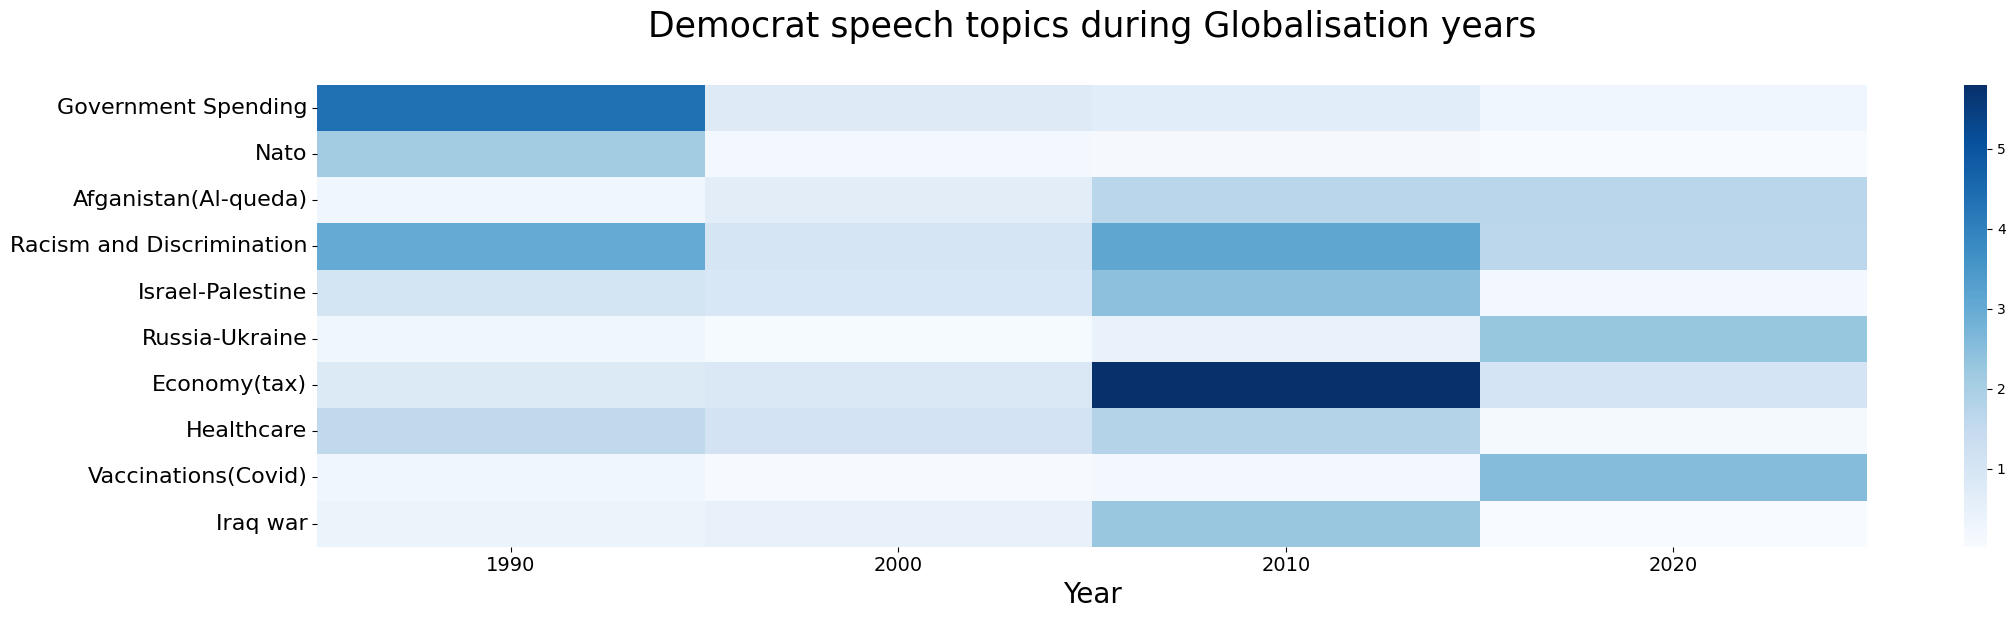

In [28]:
# NMF topic model code and plotting from 
# https://towardsdatascience.com/analysis-of-presidential-speeches-throughout-american-history-bb088d36d7dd


# Importing correct vectorizers here trying both count and tf-idf, tf-idf seems to generate more coherent results and considers semantics
# in a better sence than just pure frequencies such as Count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Splitting into democrats
dfglob_d = df1[(df1['Time_Periods'] == 'Globalization') & (df1['Party'] == 'Democratic')]

# Splitting into Republicans 
dfglob_r = df1[(df1['Time_Periods'] == 'Globalization') & (df1['Party'] == 'Republican')]


## Splitting dataset into speech
X = dfglob_d.Speech

# Name of president  
y = dfglob_d.Name


# Trying with count vectorizer with max_df =0.4 as it generated the most coherent results
cv1 = CountVectorizer(max_df=0.4,min_df = 5)

# Tf-idf with max-df = 0.7 as it generated the most coherent results
cv2 = TfidfVectorizer(max_df=0.7)

# Making a document term matrix for Count Vectorizer
doc_matrix_cv = cv1.fit_transform(X)

# Making a document term matrix for TF-IDF
doc_matrix_tf = cv2.fit_transform(X)

# Running a NMF model with 10 Topics initially 
nmf = NMF(n_components = 10)

# Fitting to the document term matrix
topics = nmf.fit_transform(doc_matrix_tf)


# Making a dataframe of the Topic words 
topic_word_nmf = pd.DataFrame(nmf.components_.round(3),
# Making the Indez for them, more topics there so no need to write more if number of output topics
index = ["topic_1","topic_2", "topic_3","topic_4", "topic_5", "topic_6","topic_7", "topic_8","topic_9", "topic_10"]# "topic_11"]#, "topic_12", "topic_13", "topic_14", "topic_15", "topic_16", "topic_17",  "topic_18"],
# Getting the feature names as columns
,columns = cv2.get_feature_names_out())


# Displaying the topics with the topics with hightest probablity shown first
def display_topics(model, feature_names, number_top_words):
    for index, topic in enumerate(model.components_):
        print("\nTopic ", index)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-number_top_words - 1:-1]]))


# Making a dataframe here, topics are not generated the same each time so beware the topic words can change
# The labels here just represent the iteraiton of what the topics represented at that point in time
doc_topic_nmf = pd.DataFrame(topics,
                             index = dfglob_d.Year.astype(int), 
                             columns = ["Government Spending","Nato", "Afganistan(Al-queda)","Racism and Discrimination","Israel-Palestine",  
                     "Russia-Ukraine","Economy(tax)", "Healthcare","Vaccinations(Covid)", "Iraq war"#, "Space", "Social Issues" ,"Social Issues"#,"Social Issues", "Social Issues",
                    #  "Social Issues", "Social Issues", "Social Issues"
                     ])

# Grouping by operatio
dtn = doc_topic_nmf.groupby(doc_topic_nmf.index).sum()

dtn.reset_index(level = 0, inplace = True)

# Grouping by each decade as the era spans a long period of time each year would be too much better to make a decade
graph_topics = dtn.groupby(dtn.Year // 10 * 10).sum()

# Now dropping the Year columns
graph_topics.drop(['Year'], axis=1, inplace = True) 
graph_topics.head()

# Plotting the topics based on which decade this belong to 
plt.figure(figsize = (25, 6))
sns.heatmap(graph_topics.T, annot=False, cbar=True, cmap="Blues")
plt.xlabel('Year', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 16)
plt.title('Democrat speech topics during Globalisation years\n', fontsize=25)
plt.savefig('Speech_heatmap.png');

display_topics(nmf,cv2.get_feature_names_out(),10 )

### Here the NMF model is being fine tuned based on the Word2Vec coherence score
This block before taken from 
https://github.com/derekgreene/topic-model-tutorial/blob/master/2%20-%20NMF%20Topic%20Models.ipynb

Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
K=10: Coherence=0.8082
K=11: Coherence=0.8158
K=12: Coherence=0.8214
K=13: Coherence=0.8162
K=14: Coherence=0.7951
K=15: Coherence=0.8105
K=16: Coherence=0.7947
K=17: Coherence=0.7922
K=18: Coherence=0.7956
K=19: Coherence=0.8015
K=20: Coherence=0.8043


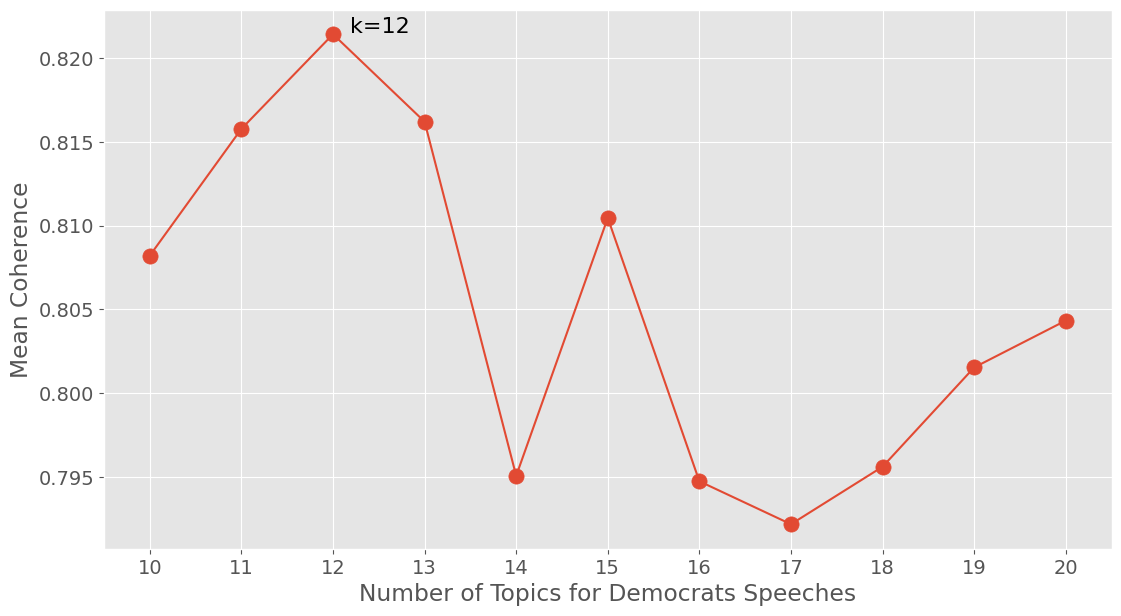

In [198]:
#Code from https://github.com/derekgreene/topic-model-tutorial/blob/master/2%20-%20NMF%20Topic%20Models.ipynb
import re
from itertools import combinations
import matplotlib

kmin, kmax = 10, 20

topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform(doc_matrix_cv)
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok.lower() in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok.lower() )
            yield tokens

docgen = TokenGenerator(testing_for_wv, [])
w2v_model = gensim.models.Word2Vec(docgen)#, min_count=20, sg=1)

def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            #print(str(pair[0]) + " " + str(pair[1]))
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(cv1.get_feature_names_out(), H, topic_index, 10))
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence(w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

%matplotlib inline
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics for Democrats Speeches")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

#### NMF For republican president speeches during the globalisaiton era
Code adapted from https://towardsdatascience.com/analysis-of-presidential-speeches-throughout-american-history-bb088d36d7dd


Topic  0
iran, soleimani, regime, isi, iranian, deal, sovereignty, terrorist, venezuela, prosperity

Topic  1
lot, think, got, really, laughter, biden, big, okay, look, democrat

Topic  2
iraq, iraqi, terrorist, saddam, troop, enemy, regime, al, extremist, baghdad

Topic  3
tax, health, school, tonight, bill, relief, senior, care, cut, plan

Topic  4
kuwait, iraq, saddam, aggression, gulf, hussein, saudi, oil, coalition, tonight

Topic  5
virus, coronavirus, testing, test, health, governor, dr, think, ventilator, ahead

Topic  6
justice, judge, court, supreme, constitution, hero, oath, school, liberty, tonight

Topic  7
cell, stem, research, human, scientist, ethical, science, line, disease, potential

Topic  8
border, immigration, drug, immigrant, illegal, worker, temporary, agent, patrol, southern

Topic  9
soviet, democracy, liberty, democratic, economic, leadership, international, cold, europe, interest

Topic  10
terrorist, terror, afghanistan, tonight, intelligence, enemy, homel

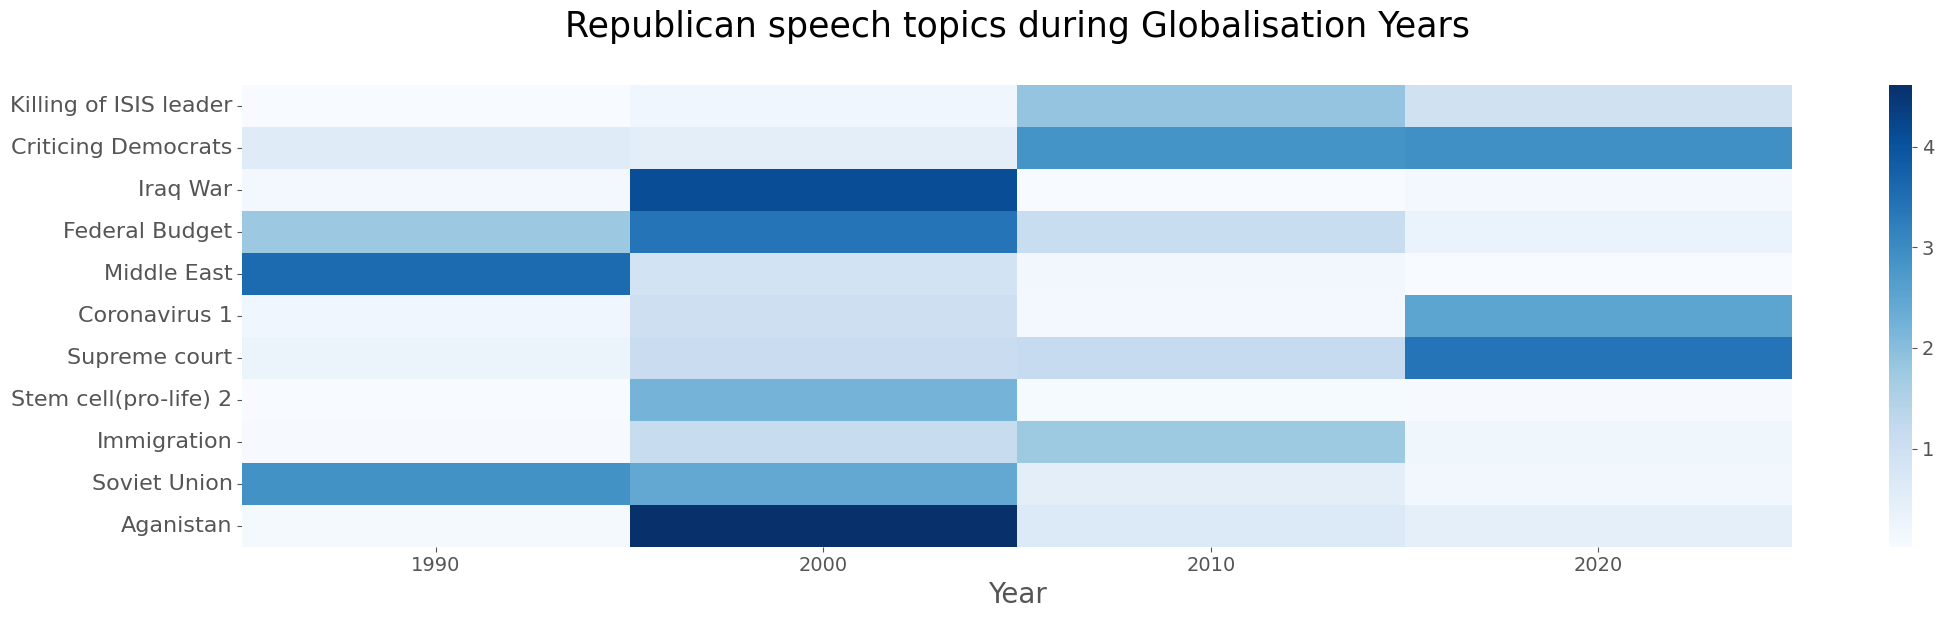

In [234]:
# NMF topic model code from https://towardsdatascience.com/analysis-of-presidential-speeches-throughout-american-history-bb088d36d7dd
X = dfglob_r.Speech
y = dfglob_r.Name


cv1 = CountVectorizer(max_df=0.4,min_df = 5)
cv2 = TfidfVectorizer(max_df=0.6, min_df=5)
doc_matrix_cv = cv1.fit_transform(X)
doc_matrix_tf = cv2.fit_transform(X)

nmf = NMF(n_components = 11)
topics = nmf.fit_transform(doc_matrix_tf)

topic_word_nmf = pd.DataFrame(nmf.components_.round(3),
index = ["topic_1","topic_2", "topic_3","topic_4", "topic_5", "topic_6","topic_7", "topic_8","topic_9", "topic_10", "topic_11"]#, "topic_12", "topic_13"]#, "topic_14", "topic_15", "topic_16", "topic_17"],
,columns = cv2.get_feature_names_out())


def display_topics(model, feature_names, number_top_words):
    for index, topic in enumerate(model.components_):
        print("\nTopic ", index)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-number_top_words - 1:-1]]))

doc_topic_nmf = pd.DataFrame(topics,
                             index = dfglob_r.Year.astype(int), 
                             columns = ["Killing of ISIS leader","Criticing Democrats", "Iraq War","Federal Budget","Middle East",  
                     "Coronavirus 1","Supreme court", "Stem cell(pro-life) 2","Immigration", "Soviet Union", "Aganistan"#,"Stem cell(pro-life)", "Stem cell(pro-life)", "Stem cell(pro-life)"
                     #, "Stem cell(pro-life)", "Stem cell(pro-life)", "Stem cell(pro-life)" 
                     ])
dtn = doc_topic_nmf.groupby(doc_topic_nmf.index).sum()

dtn.reset_index(level = 0, inplace = True)
graph_topics = dtn.groupby(dtn.Year // 10 * 10).sum()
graph_topics.drop(['Year'], axis=1, inplace = True) 
graph_topics.head()

plt.figure(figsize = (25, 6))
sns.heatmap(graph_topics.T, annot=False, cbar=True, cmap="Blues")
plt.xlabel('Year', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 16)
plt.title('Republican speech topics during Globalisation Years\n', fontsize=25)
plt.savefig('Speech_heatmap.png');

display_topics(nmf,cv2.get_feature_names_out(),10 )

Fine Tuning Republican NMF Moddel 
Code adapted from https://github.com/derekgreene/topic-model-tutorial/blob/master/2%20-%20NMF%20Topic%20Models.ipynb

Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
K=10: Coherence=0.7403
K=11: Coherence=0.7548
K=12: Coherence=0.7684
K=13: Coherence=0.7714
K=14: Coherence=0.7680
K=15: Coherence=0.7536
K=16: Coherence=0.7691
K=17: Coherence=0.7597
K=18: Coherence=0.7618
K=19: Coherence=0.7556
K=20: Coherence=0.7592


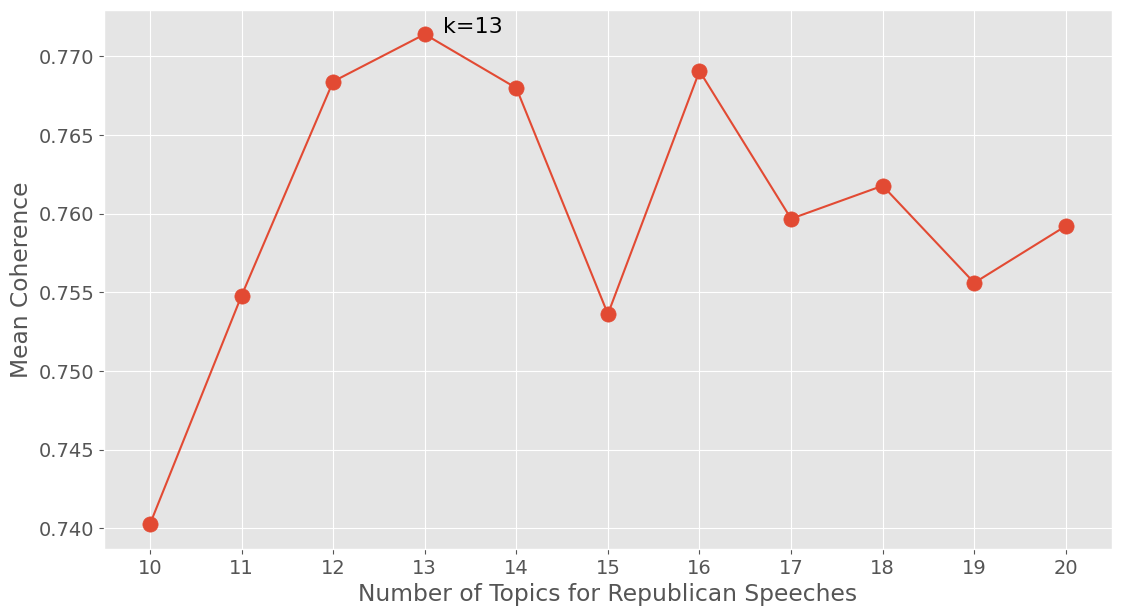

In [202]:
#Code from https://github.com/derekgreene/topic-model-tutorial/blob/master/2%20-%20NMF%20Topic%20Models.ipynb
import re
from itertools import combinations
import matplotlib

kmin, kmax = 10, 20

topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform(doc_matrix_cv)
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok.lower() in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok.lower() )
            yield tokens

docgen = TokenGenerator(testing_for_wv, [])
w2v_model = gensim.models.Word2Vec(docgen)#, min_count=20, sg=1)

def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            #print(str(pair[0]) + " " + str(pair[1]))
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append(get_descriptor(cv1.get_feature_names_out(), H, topic_index, 10))
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence(w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

%matplotlib inline
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics for Republican Speeches")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

### NMF Filtering Pipeline
### Also before doing anything I am training my word2vec model based on the helper funciton defined in the top cell in order to get similarity for words assocaited with each topic

### 1) Topic Modelling using NMF on seperate republican and democrat datasets 
     * Here using gensim instead of scikit learn using gensim as more usable for my pipeline and got more funcitonality
     * Still not great for plotting in my opinion

### 2) Finding the most similar topics between democrat topics and republican topics
     * After this returning top five most similar topics 
     * Such as a (Democrat topic numebr 1, Republican topic number 3) are very similar based on the results

### 3) After Finding most similar topic find the associated republican speech and democrat speeches
    * So if republican topic = 1 and democratic topic = 3 are the most similar, top 10 democrat speeches associated with topic number 3 will be returnd, likewise for republicans

### 4) After finding the associated speeches with the topics gather their summaries
     * In their summaries I use 2 different models my word2vec model and the bert model
     * The reason for the bert model is that it considers semantics unlike my word2vec model
     * I create a matrix which measures the similarity of the summaries is measured

#### 5) Eventually return the speeches with the most similar topics, and nost similar summaries 
     * In this pipeline even though similar topics is calculted in a manner such that semantics are not considered because topic words are standalone
     * Also topic modelling is done with bag of words model because of the sheer size of the documents
     * Hence to make sure semantics and context is considered I also use a bert based model during the comparisons of summaries


In [93]:
import gensim 
import spacy
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Building a bigram and trigram model to test how we do
bigram = gensim.models.Phrases(df1.Speech, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df1.Speech], threshold=100) 

bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) # to save time

embedding_model = Word2vec(df1,params={'workers':3,'sample':1e-7})


# These 4 functions taken from https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
def build_bigram(corpus):
    return [bigram_model[doc] for doc in corpus]


def make_trigrams(texts):
    return [trigram_model[bigram_model[doc]] for doc in texts]


def lemmatizationTagging(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Taken this code from here
    https://spacy.io/api/annotation
    Just annotated as lemmatization differnt based on POS tagging to just make sure coorect one
    """
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


def remove_stopwords(texts : list, df : pd.DataFrame, min_len : int) -> list:
    stop_words = generate_stopwords(dataframe=df)
    return [[word for word in simple_preprocess(str(doc), min_len=min_len) if word not in stop_words] for doc in texts]


def preprocessNmf(dataframe : pd.DataFrame, bigram : bool = True, trigram : bool = False, text_col : str = 'Speech', min_len : int = 3) -> list:
    """
    This is to make bigrams, trigrams and the lemmatization for the dataset
    """
    # Remove Stop Words
    data_words_nostops = remove_stopwords(texts = dataframe[text_col], df = dataframe, min_len=min_len)
    # Form Bigrams
    data_words_bigrams = build_bigram(data_words_nostops)
    data_lemmatized = lemmatizationTagging(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    return data_lemmatized


def buildNMF(dataframe : pd.DataFrame, df_min : int = 5, df_max : float = None, verbose : bool = True, num_words : int =15, probabilities : bool = False, num_topics:int = 10):
    """
    This function builds a NMF model on the dataframe and the paramters can be toggled with
    Based on the desired output toggle the parameters for different or better results
    Also to print out topic names keep Verbose as True
    """
    from gensim.models import CoherenceModel, LdaModel, TfidfModel
    cleanedData = preprocessNmf(dataframe)
    # Create Dictionary
    id2word = corpora.Dictionary(cleanedData)
    id2word.filter_extremes(no_below=df_min, no_above=df_max, keep_n=20000)  # filter out too in/frequent tokens

    # Filtering dictionary for removing words which are in 90 % of the documents 
    # id2word.filter_extremes(no_below=0.1, no_above=0.9)
    # Create Corpus

    texts = cleanedData
    tfidf = TfidfModel(dictionary=id2word)
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    corpus_tf = list(tfidf[corpus])
    # # View
    # if verbose :
    #     print(corpus[:1][0][:30])
    # Build LDA model
    nmf_model = gensim.models.Nmf(
            corpus=corpus,
            num_topics=num_topics,
            id2word=id2word,
            chunksize=1000,
            passes=5,
            eval_every=10,
            minimum_probability=0,
            random_state=0,
            kappa=1,
        )

    if verbose :
        # Print the Keyword in the 10 topics
        pprint(nmf_model.show_topics())
        # pprint(lda_model.print_topics())
        # lda_model.print_topics()
        # doc_lda = lda_model[corpus]

    topics = {}
    for index, topic in nmf_model.show_topics(formatted=False, num_words=num_words):
    # print(index)
        words = [word[0] for word in topic]
        # probabilities = [word[1] for word in topic]
        topics.update({index : words})

    print(CoherenceModel(
        model=nmf_model,
        corpus=corpus_tf,
        coherence='u_mass'
    ).get_coherence())

    df_topic_words = pd.DataFrame.from_dict(topics)
    titles = []
    for i in range(num_topics):
        title = 'title' + str(i)
        titles.append(title)
    df_topic_words.columns = titles
    return nmf_model, cleanedData, corpus, df_topic_words


# Code from https://stackoverflow.com/questions/63777101/topic-wise-document-distribution-in-gensim-lda
def associated_docs(model : gensim.models, corpus : list, topic_number : int, num_topics : int) -> list:
    """
    This is to get the speeches assocaited with the documents
    Only works with gensim models 
    Again code from stack overflow
    Returns top 10 scored docs or speeches in our cas
    input which topic you want the associated docs for 
    """
    # setup: get the model's topics in their native ordering...
    all_topics = model.print_topics()
    # ...then create a empty list per topic to collect the docs:
    docs_per_topic = [[] for _ in all_topics]

    # now, for every doc...
    for doc_id, doc_bow in enumerate(corpus):
        # ...get its topics...
        doc_topics = model.get_document_topics(doc_bow)
        # ...& for each of its topics...
        for topic_id, score in doc_topics:
            # ...add the doc_id & its score to the topic's doc list
            docs_per_topic[topic_id].append((doc_id, score))

    # Get docs in order of greatest scores wiht the topics
    for doc_list in docs_per_topic:
        doc_list.sort(key=lambda id_and_score: id_and_score[1], reverse=True)

    return docs_per_topic[topic_number][:num_topics]


def get_sentences(dataframe : pd.DataFrame) -> str :
    '''
    Join the words associated with each topic in a sentence to get overall sentences
    This is then used to base similarity between topics 
    '''
    l = []
    for col in dataframe.columns:
        l.append(' '.join(dataframe[col]))
    return '.'.join(l)


def get_sentences_of_topics(dataframe : pd.DataFrame) -> str :
    '''
    Join the words associated with each topic in a sentence to get overall sentences
    This is then used to base similarity between topics 
    '''
    l = []
    for col in dataframe.columns:
        l.append(' '.join(dataframe[col]))
    return l


def similar_topicsv1(democratic_df_topic_words : pd.DataFrame, republican_topic_words_df : pd.DataFrame, top_n_topics : int = 5):
    '''
    Two approaches done here one is to make a sentence of each topic word and then embed the sentence
    There also another approach which is slightly different which essentially permutes every single 
    topic word with every other topic in the other topic list, every expensive operation
    this then basically for 15 words gives a max of 15 and then the topics with highest cosine similarity are chosen as the 
    most similar topics
    '''
    # List for topic number
    topic_no = []

    # for eaach column
    for i in range(len(democratic_df_topic_words.columns)):

        # append the topic numebr
        topic_no.append('title' + str(i))
    
    # Get the topic words for democrats 
    democratic_df_topic_words.columns = topic_no

    # Get the topic words for republicans
    republican_topic_words_df.columns = topic_no

    # Make a dictionary with the key being a tuple of topic 1 dem , topic 3 rep and make 100 of these pumutaitons
    # obviously number of permutaitons based on the number of topics u have for each democrat and republican
    values = {}
    for col in republican_topic_words_df.columns:
        for col_dem in democratic_df_topic_words.columns:
            newting = pd.concat([republican_topic_words_df[col],democratic_df_topic_words[col_dem]],axis=1)
            newting.columns = ['bro','ski']
            suming = 0
            for i in range(len(newting)):

                # Calculating the cosine similarity
                suming += cosine_similarity(embedding_model.wv[newting['bro'][i]].reshape(1,-1),embedding_model.wv[newting['ski'][i]].reshape(1,-1))[0][0]
            
            # Update the dictionary  with the key value paring
            values.update({(col,col_dem):suming})

    # Sorting them out based on the highest similarity again a paramter here
    top_five = sorted(values.items(), key=lambda x: (-x[1], x[0]))[:top_n_topics]

    # These are all the topic tuples ranked
    everything = sorted(values.items(), key=lambda x: (-x[1], x[0]))

    # Making it into a dataframe 
    newdfs = []
    for i in range(len(top_five)):
        newdfs.append(pd.concat([republican_topic_words_df[str(top_five[i][0][0])],democratic_df_topic_words[str(top_five[i][0][1])]],axis=1))

    # Retuting top_five mosst similar republican and democratic topics, the dataframe, and then all the topics
    return top_five, newdfs, everything


def similar_topicsv2(republican_topic_words_df, democratic_df_topic_words, topic_dem_sents : list, topic_rep_sents : list, top_n_topics : int = 5):
    topic_no = []

    # for eaach column
    for i in range(len(democratic_df_topic_words.columns)):

        # append the topic numebr
        topic_no.append('title' + str(i))
    
    differnces = {}
    for i in range(len(topic_dem_sents)):
        for j in range(len(topic_rep_sents)):
            differnces.update({(topic_no[i],topic_no[j]) : sentence_sim(topic_dem_sents[i],topic_rep_sents[j])})
        # Sorting them out based on the highest similarity again a paramter here
    top_five = sorted(differnces.items(), key=lambda x: (-x[1], x[0]))[:top_n_topics]

    # These are all the topic tuples ranked
    everything = sorted(differnces.items(), key=lambda x: (-x[1], x[0]))

    # Making it into a dataframe 
    newdfs = []
    for i in range(len(top_five)):
        newdfs.append(pd.concat([democratic_df_topic_words[str(top_five[i][0][0])],republican_topic_words_df[str(top_five[i][0][1])]],axis=1))
    return top_five, newdfs, everything
    

def sentence_sim(sentence1 : str, sentence2 : str):
    # Concatinating the sentences together
    sentences = [sentence1, sentence2]
    # Using the pretrained moedl here 
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    # Generating the embeddigns here for those sentences
    embeddings = model.encode(sentences)
    # Calculating the cosine similarity for those sentends
    dis_bert = cosine_similarity(embeddings[0].reshape(1,-1),embeddings[1].reshape(1,-1))
    return dis_bert


def sentence_similarity(sentence1 : str, sentence2 : str ,Bert : bool = True, word2vec : bool = False):
    """
    This here is for sentence similarity using 2 different models one word2vec and the other bert based model
    The bert based makes more sense as this is used for summaries which is full sentences so generating embeddings for that
    make better sense
    """
    values = []
    # again values array

    # controlled by boolean if bert model wanted or word2vec
    if Bert :
        from sentence_transformers import SentenceTransformer

        # Concatinating the sentences together
        sentences = [sentence1, sentence2]

        # Using the pretrained moedl here 
        model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

        # Generating the embeddigns here for those sentences
        embeddings = model.encode(sentences)

        # Calculating the cosine similarity for those sentends
        dis_bert = cosine_similarity(embeddings[0].reshape(1,-1),embeddings[1].reshape(1,-1))

        # If both true and then it returns array with both
        if Bert and word2vec:
            values.append(dis_bert)
        else:
            return dis_bert

    # If word2vec chosen as the model
    if word2vec :

        # Tokenise the first sentence
        first_sen = nltk.tokenize.word_tokenize(sentence1)

        # Generate embeddings 
        second_sen = nltk.tokenize.word_tokenize(sentence2)

        # Then Do list comprehension
        embedding_1 = [embedding_model.wv[word] for word in first_sen]

        # List comprehension
        embedding_2 = [embedding_model.wv[word] for word in second_sen]

        # Calculate the cosine similarity
        dis_word2vec = cosine_similarity(embedding_1[0].reshape(1,-1),embedding_2[1].reshape(1,-1))

        # Giving if both true 
        if Bert and word2vec:
            values.append(dis_word2vec)
        else: 
            return dis_word2vec

    # So return 2 arrays if both booleans true
    if Bert and word2vec:
        return values[0],values[1]


def most_similar_doc(ass_rep_speeches : list, ass_dem_speeches : list, democratic_dataframe : pd.DataFrame, republican_dataframe : pd.DataFrame, plotting : bool = True) -> np.array:
    """
    This is to create a square matrix with values representing the similarity between the 2 summaries
    This eventually is the last filtering stage
    """
    differnces = np.zeros((len(ass_dem_speeches),len(ass_rep_speeches)))
    for i in range(len(ass_dem_speeches)):
        for j in range(len(ass_rep_speeches)):
            # print(democratic_dataframe.iloc[ass_dem_speeches[i][0],:]['Speech_Summary'].lower())
            # print(republican_dataframe.iloc[ass_rep_speeches[j][0],:]['Speech_Summary'].lower())
            similarity = sentence_similarity(democratic_dataframe.iloc[ass_dem_speeches[i][0],:]['Speech_Summary'].lower(),republican_dataframe.iloc[ass_rep_speeches[j][0],:]['Speech_Summary'].lower(), word2vec=False)
            # print(similarity)
            differnces[i][j] = similarity
    i,j = np.unravel_index(differnces.argmax(), differnces.shape)
    if plotting:
        ax = sns.heatmap(differnces, linewidths=0.5)    
        plt.show()
    return differnces, i, j


def filtering(republican_topic_model : gensim.models, republican_corpus : list, democratic_topic_model : gensim.models, 
            democratic_corpus : list, democratic_df : pd.DataFrame, republican_df : pd.DataFrame,  
            params_rep: dict = {'topic_number':3, 'num_topics':10}, params_dem: dict = {'topic_number':9, 'num_topics':3}
            ):

    """
    Overall Filtering funciton which performs the filtering given the 2 most simialr topics you want ot filter for
    """
    # Topic 3 republicans 
    ass_rep_speeches = associated_docs(model=republican_topic_model,corpus=republican_corpus, **params_rep)
    # Topic 9 for democrats
    ass_dem_speeches = associated_docs(model=democratic_topic_model,corpus=democratic_corpus, **params_dem)
    if len(ass_dem_speeches) == 0 :
        print('No democratic speeches associated with this topic number', params_dem['topic_number'])
        return
    elif len(ass_dem_speeches) == 0 :
        print('No republican speeches associated with this topic', params_rep['topic_number'])
        return
    else:
        differnces, best_dem_speech, best_rep_speech = most_similar_doc(ass_dem_speeches=ass_dem_speeches, ass_rep_speeches = ass_rep_speeches, democratic_dataframe=democratic_df, republican_dataframe=republican_df)
        return differnces, best_dem_speech, best_rep_speech

In [32]:
# Getting a list of unique time periods
tp_nmf = list(df1.Time_Periods.unique())

# Cleaning the columns necessary Title and Summary as Speeches have already been cleaned
df1_nmf = cleaning(df1, cleaning_cols=['Title','Speech_Summary'])

# Creating the dataframe for Globalisation time period
dftl_nmf = df1_nmf[(df1_nmf.Time_Periods == tp_nmf[7])]

# Splitting dataframes into Republican
dftlr_nmf = dftl_nmf[dftl_nmf['Party'] == 'Republican']

# Splitting dataframe further for democrats
dftld_nmf = dftl_nmf[dftl_nmf['Party'] == 'Democratic']

# Building a NMF Model for the republican dataframe and the parameters are there for filtering the corpus and also controlling
# Other parameters for the model itself
# Several other parameters
lda_model_rep_nmf, cleaned_data_nmf, corpus_rep_nmf, df_words_rep_nmf = buildNMF(dftlr_nmf, df_max= 0.,num_topics=10)

# Building a NMF Model for the democratic dataframe and the parameters are there for filtering the corpus and also controlling
# Other parameters for the model itself
# Several other parameters
lda_model_dem_nmf, cleaned_data_nmf,corpus_dem_nmf, df_words_dem_nmf = buildNMF(dftld_nmf, df_max=0.8,num_topics=10)

[(0, '0.028*"really" + 0.026*"lot" + 0.022*"laughter" + 0.016*"big" + 0.015*"incredible" + 0.014*"guy" + 0.014*"run" + 0.011*"approve" + 0.011*"tremendous" + 0.008*"company"'), (1, '0.036*"tax" + 0.018*"minute" + 0.016*"cut" + 0.013*"tonight" + 0.010*"income" + 0.010*"health" + 0.010*"spend" + 0.009*"cost" + 0.009*"drug" + 0.007*"aid"'), (2, '0.031*"lot" + 0.027*"drug" + 0.022*"question" + 0.021*"border" + 0.015*"wall" + 0.013*"dollar" + 0.012*"really" + 0.012*"area" + 0.012*"fact" + 0.011*"ahead"'), (3, '0.023*"governor" + 0.018*"really" + 0.018*"ventilator" + 0.015*"case" + 0.012*"test" + 0.012*"lot" + 0.011*"ahead" + 0.010*"close" + 0.010*"vice" + 0.009*"early"'), (4, '0.017*"cell" + 0.017*"research" + 0.017*"laughter" + 0.015*"vote" + 0.014*"election" + 0.013*"stem" + 0.009*"guy" + 0.009*"win" + 0.008*"science" + 0.007*"actually"'), (5, '0.008*"tonight" + 0.008*"democracy" + 0.006*"trade" + 0.006*"political" + 0.006*"decade" + 0.005*"interest" + 0.005*"old" + 0.005*"border" + 0.005

### Joining the topic words together and getting the most similar topics

In [103]:
dem_dem_ones = get_sentences_of_topics(df_words_dem_nmf)
rep_rep_ones = get_sentences_of_topics(df_words_rep_nmf)
top_five, newdfs, all = similar_topicsv2(df_words_rep_nmf, df_words_dem_nmf, dem_dem_ones, rep_rep_ones, top_n_topics=8)

In [110]:
top_five

[(('title9', 'title1'), array([[0.66773546]], dtype=float32)),
 (('title4', 'title6'), array([[0.5685158]], dtype=float32)),
 (('title5', 'title1'), array([[0.56219757]], dtype=float32)),
 (('title1', 'title1'), array([[0.5083678]], dtype=float32)),
 (('title0', 'title1'), array([[0.4707211]], dtype=float32)),
 (('title1', 'title2'), array([[0.46590415]], dtype=float32)),
 (('title9', 'title2'), array([[0.44557068]], dtype=float32)),
 (('title2', 'title8'), array([[0.44436356]], dtype=float32))]

### Topic 9 from democrats and Topic 1 from Republicans 

#### Getting the associated documents from the closest topic numbers

In [111]:
# Topic 3 republicans 
ass_rep_speeches = associated_docs(model=lda_model_rep_nmf,corpus=corpus_rep_nmf,topic_number=1, num_topics=10)

# Topic 9 for democrats
ass_dem_speeches = associated_docs(model=lda_model_dem_nmf,corpus=corpus_dem_nmf,topic_number=9, num_topics=10)

In [112]:
ass_rep_speeches

[(52, 0.9877678256837128),
 (21, 0.6447765649079569),
 (3, 0.636414670520395),
 (11, 0.5481452715948695),
 (5, 0.48342676656429917),
 (36, 0.45354813661985766),
 (4, 0.3859415381066206),
 (38, 0.3746894149977559),
 (91, 0.34715745204027365),
 (23, 0.3205974242197987)]

### Running the whole pipleline 
Run this after dont re run cell above the outputs change based different things
This code will find the most similar documents based on the summaries

In [125]:
display(ass_rep_speeches,ass_dem_speeches)

# similar_topicsg = similar_topics(democratic_df_topic_words=df_words_dem, republican_topic_words_df=df_words_rep)
similarity_matrix, most_similar_i, most_similar_j = filtering(republican_topic_model=lda_model_rep_nmf, republican_corpus=corpus_rep_nmf
                                ,democratic_topic_model=lda_model_dem_nmf, democratic_corpus=corpus_dem_nmf, 
                                democratic_df=dftld_nmf, republican_df=dftlr_nmf,
                                params_rep={'topic_number': 5,'num_topics': 10}, params_dem={'topic_number': 9,'num_topics': 10})

[(71, 0.6257946196828775),
 (70, 0.3688478188692365),
 (69, 0.24158758875316794),
 (89, 0.22935144050203324),
 (31, 0.21435617691406159),
 (62, 0.13353165328163133),
 (64, 0.12908863200899337),
 (2, 0.10655196232862782),
 (68, 0.1010234371410194),
 (25, 0.09588808759310832)]

[(11, 0.4400831804271041),
 (15, 0.39715682246161765),
 (4, 0.34792394928933107),
 (5, 0.3356106136302417),
 (87, 0.3272510867930736),
 (26, 0.2786625219002911),
 (1, 0.2623266313675577),
 (8, 0.24422564071959696),
 (17, 0.22795181844604653),
 (23, 0.22354221365715957)]

Name                                                   Barack Obama
Party                                                    Democratic
From                                                           2009
To                                                             2017
Date                                            2010-09-23 00:00:00
Title                                                address nation
Speech_Summary    obama address nation general assembly new york...
Speech            secretary general fellow delegate lady gentlem...
Year                                                           2010
Time_Periods                                          Globalization
Name: 984, dtype: object

Name                                              George H. W. Bush
Party                                                    Republican
From                                                           1989
To                                                             1993
Date                                            1990-07-26 00:00:00
Title                        remark signing american disability act
Speech_Summary    bush explains importance civil right act guara...
Speech            evan much welcome every one splendid scene hop...
Year                                                           1990
Time_Periods                                          Globalization
Name: 867, dtype: object

### Important Speeches to make conclusions from These are the filtered speeches for the closest topics

### These are speeches used during the report chnages because the order of the topics generated are never the same, hence why probably wont get the same speeches again

In [ ]:
display(dftld_nmf.iloc[ass_dem_speeches[5][0],:],dftlr_nmf.iloc[ass_rep_speeches[3][0],:])
display(dftld_nmf.iloc[ass_dem_speeches[5][0],:],dftlr_nmf.iloc[ass_rep_speeches[2][0],:])
display(dftld_nmf.iloc[ass_dem_speeches[8][0],:],dftlr_nmf.iloc[ass_rep_speeches[0][0],:])

Name                                                      Joe Biden
Party                                                    Democratic
From                                                           2021
To                                                             2022
Date                                            2021-04-28 00:00:00
Title                                address joint session congress
Speech_Summary    honor first day administration joe biden addre...
Speech            good back mitch chuck understand good almost h...
Year                                                           2021
Time_Periods                                          Globalization
Name: 1059, dtype: object

Name                                                   Donald Trump
Party                                                    Republican
From                                                           2017
To                                                             2021
Date                                            2020-08-08 00:00:00
Title                              press conference executive order
Speech_Summary    donald trump begin press conference discussing...
Speech            much everybody good afternoon administration w...
Year                                                           2020
Time_Periods                                          Globalization
Name: 1011, dtype: object

Name                                                      Joe Biden
Party                                                    Democratic
From                                                           2021
To                                                             2022
Date                                            2021-04-28 00:00:00
Title                                address joint session congress
Speech_Summary    honor first day administration joe biden addre...
Speech            good back mitch chuck understand good almost h...
Year                                                           2021
Time_Periods                                          Globalization
Name: 1059, dtype: object

Name                                                 George W. Bush
Party                                                    Republican
From                                                           2001
To                                                             2009
Date                                            2001-06-07 00:00:00
Title             remark signing economic growth tax relief reco...
Speech_Summary    bush remark passage economic growth tax relief...
Speech            sit behave white house laughter laura much his...
Year                                                           2001
Time_Periods                                          Globalization
Name: 949, dtype: object

Name                                                   Barack Obama
Party                                                    Democratic
From                                                           2009
To                                                             2017
Date                                            2013-02-13 00:00:00
Title                                                 union address
Speech_Summary    obama delivers union address vice joe biden sp...
Speech            speaker vice member congress fellow citizen fi...
Year                                                           2013
Time_Periods                                          Globalization
Name: 968, dtype: object

Name                                                 George W. Bush
Party                                                    Republican
From                                                           2001
To                                                             2009
Date                                            2001-08-09 00:00:00
Title                             address nation stem cell research
Speech_Summary    bush address nation position federal funding s...
Speech            good evening appreciate giving minute time ton...
Year                                                           2001
Time_Periods                                          Globalization
Name: 948, dtype: object

#### Code below this not used in the report but kept as evident for trying the LDA model and making a pipleline with both models

### LDA Filtering Pipeline
#### Here instead of NMF LDA is used for the topic modelling stage which is when I realise that the topic words are not as coherent for LDA in comparison to NMF, but also it is hard to infer topic names from these words
Hence why this model has been abandoned

In [ ]:
import gensim 
import spacy
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity

# Building a bigram and trigram model to test how we do
bigram = gensim.models.Phrases(df1.Speech, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df1.Speech], threshold=100) 

bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_model = gensim.models.phrases.Phraser(trigram)

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) # to save time

embedding_model = Word2vec(df1,params={'workers':3,'sample':1e-7})


# These 4 functions taken from https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
def build_bigram(corpus):
    return [bigram_model[doc] for doc in corpus]


def make_trigrams(texts):
    return [trigram_model[bigram_model[doc]] for doc in texts]


def lemmatizationTagging(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


def remove_stopwords(texts : list, df : pd.DataFrame, min_len : int) -> list:
    stop_words = generate_stopwords(dataframe=df)
    return [[word for word in simple_preprocess(str(doc), min_len=min_len) if word not in stop_words] for doc in texts]


def preprocessLda(dataframe : pd.DataFrame, bigram : bool = True, trigram : bool = False, text_col : str = 'Speech', min_len : int = 3) -> list:
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(texts = dataframe[text_col], df = dataframe, min_len=min_len)
    # Form Bigrams
    data_words_bigrams = build_bigram(data_words_nostops)
    data_lemmatized = lemmatizationTagging(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    return data_lemmatized


def buildLDA(dataframe : pd.DataFrame, df_min : float = None, df_max : float = None, verbose : bool = True, num_words : int =15, probabilities : bool = False, num_topics:int = 10):
    
    cleanedData = preprocessLda(dataframe)
    # Create Dictionary
    id2word = corpora.Dictionary(cleanedData)

    # Filtering dictionary for removing words which are in 90 % of the documents 
    # id2word.filter_extremes(no_below=0.1, no_above=0.9)
    # Create Corpus

    texts = cleanedData
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # # View
    # if verbose :
    #     print(corpus[:1][0][:30])
    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                    #    per_word_topics=True
                                    )
    if verbose :
        # Print the Keyword in the 10 topics
        pprint(lda_model.print_topics())
        lda_model.print_topics()
        doc_lda = lda_model[corpus]

    topics = {}
    for index, topic in lda_model.show_topics(formatted=False, num_words=num_words):
    # print(index)
        words = [word[0] for word in topic]
        # probabilities = [word[1] for word in topic]
        topics.update({index : words})

    df_topic_words = pd.DataFrame.from_dict(topics)
    titles = []
    for i in range(num_topics):
        title = 'title' + str(i)
        titles.append(title)
    df_topic_words.columns = titles
    return lda_model, cleanedData, corpus, df_topic_words


# Code from https://stackoverflow.com/questions/63777101/topic-wise-document-distribution-in-gensim-lda
def associated_docs(model : gensim.models, corpus : list, topic_number : int, num_topics : int) -> list:
    """
    This is to get the speeches assocaited with the documents
    Only works with gensim models 
    Again code from stack overflow
    Returns top 10 scored docs or speeches in our cas
    input which topic you want the associated docs for 
    """
    # setup: get the model's topics in their native ordering...
    all_topics = model.print_topics()
    # ...then create a empty list per topic to collect the docs:
    docs_per_topic = [[] for _ in all_topics]

    # now, for every doc...
    for doc_id, doc_bow in enumerate(corpus):
        # ...get its topics...
        doc_topics = model.get_document_topics(doc_bow)
        # ...& for each of its topics...
        for topic_id, score in doc_topics:
            # ...add the doc_id & its score to the topic's doc list
            docs_per_topic[topic_id].append((doc_id, score))

    # Get docs in order of greatest scores wiht the topics
    for doc_list in docs_per_topic:
        doc_list.sort(key=lambda id_and_score: id_and_score[1], reverse=True)

    return docs_per_topic[topic_number][:num_topics]


def get_sentences(dataframe : pd.DataFrame) -> str :
    '''
    Join the words associated with each topic in a sentence to get overall sentences
    '''
    l = []
    for col in dataframe.columns:
        l.append(' '.join(dataframe[col]))
    return '.'.join(l)


def similar_topics(democratic_df_topic_words : pd.DataFrame, republican_topic_words_df : pd.DataFrame, top_n_topics : int = 5):
    topic_no = []
    for i in range(len(democratic_df_topic_words.columns)):
        topic_no.append('title' + str(i))
    democratic_df_topic_words.columns = topic_no
    republican_topic_words_df.columns = topic_no
    values = {}
    for col in republican_topic_words_df.columns:
        for col_dem in democratic_df_topic_words.columns:
            newting = pd.concat([republican_topic_words_df[col],democratic_df_topic_words[col_dem]],axis=1)
            newting.columns = ['bro','ski']
            suming = 0
            for i in range(len(newting)):
                suming += cosine_similarity(embedding_model.wv[newting['bro'][i]].reshape(1,-1),embedding_model.wv[newting['ski'][i]].reshape(1,-1))[0][0]
            values.update({(col,col_dem):suming})

    top_five = sorted(values.items(), key=lambda x: (-x[1], x[0]))[:top_n_topics]
    everything = sorted(values.items(), key=lambda x: (-x[1], x[0]))
    newdfs = []
    for i in range(len(top_five)):
        newdfs.append(pd.concat([republican_topic_words_df[str(top_five[i][0][0])],democratic_df_topic_words[str(top_five[i][0][1])]],axis=1))
    return top_five, newdfs, everything


def sentence_similarity(sentence1 : str, sentence2 : str ,Bert : bool = True, word2vec : bool = False):
    values = []
    if Bert :
        from sentence_transformers import SentenceTransformer
        sentences = [sentence1, sentence2]

        model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        embeddings = model.encode(sentences)
        dis_bert = cosine_similarity(embeddings[0].reshape(1,-1),embeddings[1].reshape(1,-1))
        if Bert and word2vec:
            values.append(dis_bert)
        else:
            return dis_bert

    if word2vec :
        first_sen = nltk.tokenize.word_tokenize(sentence1)
        second_sen = nltk.tokenize.word_tokenize(sentence2)
        embedding_1 = [embedding_model.wv[word] for word in first_sen]
        embedding_2 = [embedding_model.wv[word] for word in second_sen]
        dis_word2vec = cosine_similarity(embedding_1[0].reshape(1,-1),embedding_2[1].reshape(1,-1))
        if Bert and word2vec:
            values.append(dis_word2vec)
        else: 
            return dis_word2vec

    if Bert and word2vec:
        return values[0],values[1]


def most_similar_doc(ass_rep_speeches : list, ass_dem_speeches : list, democratic_dataframe : pd.DataFrame, republican_dataframe : pd.DataFrame, plotting : bool = True) -> np.array:
    differnces = np.zeros((len(ass_dem_speeches),len(ass_rep_speeches)))
    for i in range(len(ass_dem_speeches)):
        for j in range(len(ass_rep_speeches)):
            # print(democratic_dataframe.iloc[ass_dem_speeches[i][0],:]['Speech_Summary'].lower())
            # print(republican_dataframe.iloc[ass_rep_speeches[j][0],:]['Speech_Summary'].lower())
            similarity = sentence_similarity(democratic_dataframe.iloc[ass_dem_speeches[i][0],:]['Speech_Summary'].lower(),republican_dataframe.iloc[ass_rep_speeches[j][0],:]['Speech_Summary'].lower(), word2vec=False)
            # print(similarity)
            differnces[i][j] = similarity
    i,j = np.unravel_index(differnces.argmax(), differnces.shape)
    if plotting:
        ax = sns.heatmap(differnces, linewidths=0.5)    
        plt.show()
    return differnces, i, j


def filtering(republican_topic_model : gensim.models, republican_corpus : list, democratic_topic_model : gensim.models, 
            democratic_corpus : list, democratic_df : pd.DataFrame, republican_df : pd.DataFrame,  
            params_rep: dict = {'topic_number':3, 'num_topics':10}, params_dem: dict = {'topic_number':9, 'num_topics':3}
            ):
    # Topic 3 republicans 
    ass_rep_speeches = associated_docs(model=republican_topic_model,corpus=republican_corpus, **params_rep)
    # Topic 9 for democrats
    ass_dem_speeches = associated_docs(model=democratic_topic_model,corpus=democratic_corpus, **params_dem)
    if len(ass_dem_speeches) == 0 :
        print('No democratic speeches associated with this topic number', params_dem['topic_number'])
        return
    elif len(ass_dem_speeches) == 0 :
        print('No republican speeches associated with this topic', params_rep['topic_number'])
        return
    else:
        differnces, best_dem_speech, best_rep_speech = most_similar_doc(ass_dem_speeches=ass_dem_speeches, ass_rep_speeches = ass_rep_speeches, democratic_dataframe=democratic_df, republican_dataframe=republican_df)
        return differnces, best_dem_speech, best_rep_speech

(5, 3)

In [ ]:
tp = list(df1.Time_Periods.unique())
df1 = cleaning(df1, cleaning_cols=['Title','Speech_Summary'])
dftl = df1[(df1.Time_Periods == tp[7])]
dftlr = dftl[dftl['Party'] == 'Republican']
dftld = dftl[dftl['Party'] == 'Democratic']
lda_model_rep, cleaned_data, corpus_rep, df_words_rep = buildLDA(dftlr, df_max= 0.9,num_topics=10)
lda_model_dem, cleaned_data,corpus_dem, df_words_dem = buildLDA(dftld, df_max=0.8,num_topics=10)

In [ ]:
# Topic 3 republicans 
ass_rep_speeches = associated_docs(model=lda_model_rep,corpus=corpus_rep,topic_number=3, num_topics=10)

# Topic 9 for democrats
ass_dem_speeches = associated_docs(model=lda_model_dem,corpus=corpus_dem,topic_number=9, num_topics=10)

display(ass_rep_speeches,ass_dem_speeches)

display(dftld.iloc[ass_rep_speeches[1][0],:])
display(dftlr.iloc[ass_dem_speeches[1][0],:])


top_five, newdfs, all = similar_topics(democratic_df_topic_words=df_words_dem, republican_topic_words_df=df_words_rep, top_n_topics=10 )


# similar_topicsg = similar_topics(democratic_df_topic_words=df_words_dem, republican_topic_words_df=df_words_rep)
similarity_matrix, most_similar_i, most_similar_j = filtering(republican_topic_model=lda_model_rep, republican_corpus=corpus_rep
                                ,democratic_topic_model=lda_model_dem, democratic_corpus=corpus_dem, 
                                democratic_df=dftld, republican_df=dftlr,
                                params_rep={'topic_number': 5,'num_topics': 10}, params_dem={'topic_number': 9,'num_topics': 10})
display(df_words_dem, df_words_rep)
all

### Appendix code with testing somethings but not useful

In [ ]:
testing_sent = df1[df1.Time_Periods == 'Globalization']

#### Testing which one is better for Sentence Similarity by performing some error analysis

In [ ]:
list(testing_sent[testing_sent['Title'].str.contains('Jobs')]['Title'])[0]
from sentence_transformers import SentenceTransformer
sentences = ["Announcing American Jobs Plan", 'Address to Congress on the American Jobs Act']

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
# print(embeddings)
first_sen = nltk.tokenize.word_tokenize(sentences[0].lower())
second_sen = nltk.tokenize.word_tokenize(sentences[1].lower())
embedding_1 = [embedding_model.wv[word] for word in first_sen]
embedding_2 = [embedding_model.wv[word] for word in second_sen]
cosine_similarity(embedding_1[0].reshape(1,-1),embedding_2[1].reshape(1,-1))
cosine_similarity(embeddings[0].reshape(1,-1),embeddings[1].reshape(1,-1))

'Address to Congress on the American Jobs Act'

In [ ]:
tp = list(df.Time_Periods.unique())
dftl = df[(df.Time_Periods == tp[4])]
dftlr = dftl[dftl['Party'] == 'Republican']
dftld = dftl[dftl['Party'] == 'Democratic']
lda_model_rep, cleaned_data, corpus_rep, df_words_rep = buildLDA(dftlr, df_max= 0.9)
lda_model_dem, cleaned_data,corpus_dem, df_words_dem = buildLDA(dftld, df_max=0.9)

docs_dem = associated_docs(model=lda_model_dem,corpus=corpus_dem,topic_number=0)
docs_rep = associated_docs(model=lda_model_rep,corpus=corpus_rep,topic_number=0)
sent_dem = get_sentences(dataframe=df_words_dem)
sent_rep = get_sentences(dataframe=df_words_rep)

from transformers import PegasusForConditionalGeneration, AutoTokenizer
import torch

# You can chose models from following list
# https://huggingface.co/models?sort=downloads&search=google%2Fpegasus
model_name = 'google/pegasus-cnn_dailymail'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)
batch = tokenizer(sent_dem, truncation=True, padding='longest', return_tensors="pt").to(device)
batch2 =tokenizer(sent_rep, truncation=True, padding='longest', return_tensors="pt").to(device) 
translated = model.generate(**batch, max_length=200)
translated2 = model.generate(**batch2, max_length=200)
dem_transformed = tokenizer.batch_decode(translated, skip_special_tokens=True)
rep_transformed = tokenizer.batch_decode(translated2, skip_special_tokens=True)
dem_transformed = dem_transformed[0].replace('<n>','')
rep_transformed = rep_transformed[0].replace('<n>','')

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
sentences = [dem_transformed[0], rep_transformed[0]]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
cosine_similarity(embeddings[0].reshape(1,-1),embeddings[1].reshape(1,-1))

[(0,
  '0.010*"man" + 0.008*"law" + 0.008*"government" + 0.008*"make" + '
  '0.007*"work" + 0.007*"great" + 0.006*"people" + 0.005*"nation" + '
  '0.005*"good" + 0.005*"well"'),
 (1,
  '0.015*"government" + 0.008*"make" + 0.008*"year" + 0.005*"people" + '
  '0.005*"island" + 0.004*"law" + 0.004*"power" + 0.004*"great" + 0.004*"time" '
  '+ 0.004*"american"'),
 (2,
  '0.009*"agreement" + 0.009*"product" + 0.007*"trade" + 0.007*"free" + '
  '0.007*"people" + 0.006*"food" + 0.006*"duty" + 0.006*"dominion" + '
  '0.006*"natural" + 0.006*"make"'),
 (3,
  '0.011*"government" + 0.010*"make" + 0.008*"law" + 0.005*"great" + '
  '0.005*"year" + 0.005*"business" + 0.005*"increase" + 0.004*"tariff" + '
  '0.004*"foreign" + 0.004*"present"'),
 (4,
  '0.008*"government" + 0.007*"law" + 0.006*"product" + 0.005*"people" + '
  '0.004*"meat" + 0.004*"honor" + 0.004*"nation" + 0.004*"interest" + '
  '0.004*"make" + 0.003*"party"'),
 (5,
  '0.001*"violate" + 0.001*"outlaw" + 0.001*"garb" + 0.001*"concord"

array([[0.428238]], dtype=float32)

In [ ]:
dftlr.iloc[[43]]

,Name,Party,From,To,Date,Speech,Year,Time_Periods
940,George W. Bush,Republican,2001,2009,2002-09-12,"Mr. Secretary General, Mr. President,...",2002,Globalization


In [ ]:
(list(dftlr.Speech)[43])

"         Mr. Secretary General, Mr. President, distinguished delegates, and ladies and gentlemen: We meet one year and one day after a terrorist attack brought grief to my country, and brought grief to many citizens of our world. Yesterday, we remembered the innocent lives taken that terrible morning. Today, we turn to the urgent duty of protecting other lives, without illusion and without fear. [President George W. Bush addresses the United Nations General Assembly in New York City on the issues concerning Iraq Thursday, September 12. White House photo by Paul Morse.]We've accomplished much in the last year -- in Afghanistan and beyond. We have much yet to do -- in Afghanistan and beyond. Many nations represented here have joined in the fight against global terror, and the people of the United States are grateful.The United Nations was born in the hope that survived a world war -- the hope of a world moving toward justice, escaping old patterns of conflict and fear. The founding memb

In [ ]:
(list(dftld.Speech)[79])

'         Good evening.\xa0 To the United States Corps of Cadets, to the men and women of our Armed Services, and to my fellow Americans:\xa0 I want to speak to you tonight about our effort in Afghanistan -- the nature of our commitment there, the scope of our interests, and the strategy that my administration will pursue to bring this war to a successful conclusion.\xa0 It\'s an extraordinary honor for me to do so here at West Point -- where so many men and women have prepared to stand up for our security, and to represent what is finest about our country.To address these important issues, it\'s important to recall why America and our allies were compelled to fight a war in Afghanistan in the first place.\xa0 We did not ask for this fight. On September 11, 2001, 19 men hijacked four airplanes and used them to murder nearly 3,000 people.\xa0 They struck at our military and economic nerve centers.\xa0 They took the lives of innocent men, women, and children without regard to their faith

In [ ]:
speech

993             Good evening.  To the United States C...
Name: Speech, dtype: object

In [ ]:
docs_dem

[(79, 0.99950576),
 (63, 0.99887866),
 (3, 0.998788),
 (2, 0.9987006),
 (33, 0.9977315),
 (61, 0.9976242),
 (95, 0.98437285),
 (66, 0.9786109),
 (48, 0.8833165),
 (78, 0.8820548)]

In [ ]:
tp = list(df.Time_Periods.unique())
dft1 = df[(df.Time_Periods == tp[0]) | (df.Time_Periods == tp[1]) | (df.Time_Periods == tp[2])]
dft2 = df[(df.Time_Periods == tp[2]) | (df.Time_Periods == tp[3]) | (df.Time_Periods == tp[4])]
dft3 = df[(df.Time_Periods == tp[5]) | (df.Time_Periods == tp[6]) | (df.Time_Periods == tp[7])]
alldf = [dft1, dft2, dft3]

models = {}
i = 0
for dfts in alldf:
    lda_model, cleanedData, id2word = buildLDA(dfts)
    models.update({i : [lda_model, cleanedData, id2word]})
    i += 1

[(0,
  '0.018*"power" + 0.012*"government" + 0.010*"constitution" + 0.007*"public" '
  '+ 0.007*"make" + 0.006*"law" + 0.006*"people" + 0.006*"act" + '
  '0.005*"general" + 0.005*"question"'),
 (1,
  '0.013*"government" + 0.009*"power" + 0.009*"people" + 0.007*"public" + '
  '0.006*"nation" + 0.005*"interest" + 0.004*"duty" + 0.004*"great" + '
  '0.004*"make" + 0.004*"time"'),
 (2,
  '0.016*"general" + 0.012*"say" + 0.011*"grant" + 0.011*"order" + '
  '0.008*"conversation" + 0.007*"office" + 0.006*"letter" + 0.006*"war" + '
  '0.006*"department" + 0.006*"give"'),
 (3,
  '0.012*"treaty" + 0.010*"government" + 0.007*"make" + 0.006*"line" + '
  '0.006*"article" + 0.005*"part" + 0.005*"nation" + 0.004*"great" + '
  '0.004*"people" + 0.004*"time"'),
 (4,
  '0.012*"government" + 0.008*"make" + 0.007*"public" + 0.006*"great" + '
  '0.006*"year" + 0.005*"power" + 0.005*"present" + 0.005*"interest" + '
  '0.005*"subject" + 0.005*"nation"'),
 (5,
  '0.014*"government" + 0.008*"make" + 0.008*"pub